# Active-learning tutorial: Using committee MACE models to study protonated water clusters

1. Load all the modules
2. read the training pool 
3. select random training set of 25 structure from the pool (can be done with np.rand) --> latter exclude these from the pool
4. Train a committee (just to check we can train 2)
5. predict on the training pool and sort max energy error
6. Then we repeat in a for loop.

## To Do 

- for loop everywhere
- avoid using scripts for MACE
- fix E0s

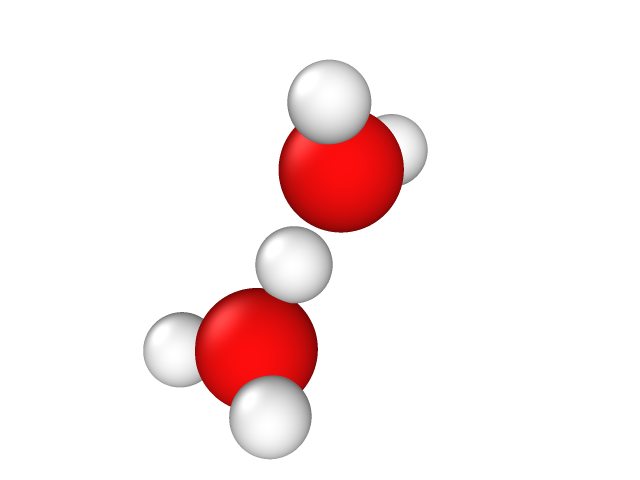

In [2]:
from IPython.display import Image, display
display(Image(filename='../initial-datasets/zundel/zundel.png'))

## Import modules

In [13]:
import os, sys
import multiprocessing
from pathlib import Path
from tqdm.notebook import tqdm
from contextlib import redirect_stdout, redirect_stderr

import numpy as np
import matplotlib.pyplot as plt

from ase.io import read, write                                      # read and write structures
from ase.visualize import view                                      # visualize structures (optional)
from mace.cli.run_train import main as mace_run_train_main          # train a MACE model
from mace.cli.eval_configs import main as mace_eval_configs_main    # evaluate a MACE model

np.random.seed(0)

# import warnings
# import logging
# 

In [4]:
plt.style.use('notebook.mplstyle')

In [5]:
# definition of some helper functions
def extxyz2energy(file:str,keyword:str="MACE_energy"):
    """Extracts the energy values from an extxyz file and returns a numpy array
    """
    atoms = read(file, index=':')
    data = np.zeros(len(atoms),dtype=float)
    for n,atom in enumerate(atoms):
        data[n] = atom.info[keyword]
    return data

def train_mace(config:str):
    """Train a MACE model using the provided configuration file.
    """
    sys.argv = ["program", "--config", config]
    mace_run_train_main()
    
def eval_mace(model:str,infile:str,outfile:str):
    """Evaluate a MACE model.
    """
    sys.argv = ["program", "--config", infile,"--output",outfile,"--model",model]
    mace_eval_configs_main()

def retrain_mace(config:str):
    """Train a MACE model using the provided configuration file.
    """
    sys.argv = ["program", "--config", config]
    mace_run_train_main()

In [6]:
os.makedirs('config', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('structures', exist_ok=True)
# os.makedirs('log', exist_ok=True)
# os.makedirs('chk', exist_ok=True)
# os.makedirs('results', exist_ok=True)

In [7]:
n_init_train = 20
n_test = 50  
n_committee = 4
parallel = False

## Select initial training structures

In [8]:
# Read the all the structures from file
structures = read('../initial-datasets/zundel/train.extxyz', index=':')
print(f'Total number of structures: {len(structures)}')
# view(structures)  # Opens an interactive GUI window to visualize the structures

Total number of structures: 10001


In [9]:
# Create the initial training and test sets
selected_indices = np.random.choice(len(structures), size=(n_init_train + n_test), replace=False)
remaining_candidate_idcs = np.delete(np.arange(len(structures)), selected_indices)

indices_train = selected_indices[:n_init_train]
indices_test = selected_indices[n_init_train:]
assert len(indices_train) == n_init_train
assert len(indices_test) == n_test

print(f'\nSelected indices for training: {indices_train}')
print(f'\nSelected indices for test: {indices_test}')

initial_training_set = [structures[i] for i in indices_train]
test_set = [structures[i] for i in indices_test]
remaining_structures = [structures[i] for i in remaining_candidate_idcs]

print(f"\nSaving the initial training set to 'structures/init.train.extxyz'")
write('structures/init.train.extxyz', initial_training_set, format='extxyz')

print(f"\nSaving the test set to 'structures/test.extxyz'")
write('structures/test.extxyz', test_set, format='extxyz')

print(f"\nSaving the remaining structures to 'structures/remaining.extxyz'")
write('structures/remaining.extxyz', remaining_structures, format='extxyz')


Selected indices for training: [9395  898 2398 4737 2343 5111 5507 6452 2670 3188 1087 1819 2308 6085
 3725 8704 7052 8563 2702 6782]

Selected indices for test: [2931 8754 8229 4463 3032 3214 3018  382 4238 7693 4269 3192 7842 8057
 9367 5335 8865 9033  580 9038 6078 8232 7677 4220 8776 9911 4612 5300
 5603 3481 6735 7062 7384 3083 3833 2821 6969 2375 1478 5014 1559 8886
 7609 5560 9085 2933 3202  713 6258 3719]

Saving the initial training set to 'structures/init.train.extxyz'

Saving the test set to 'structures/test.extxyz'

Saving the remaining structures to 'structures/remaining.extxyz'


## Initial Training

Hyperparameters for the committee members

In [14]:
# Define different values for each config
os.makedirs('config', exist_ok=True)
seeds = np.random.randint(0, 2**32 - 1, size=n_committee, dtype=np.uint32)
for i in range(n_committee):
    filename = f"config/config.{i}.yml"
    name = f"mace.com={i}"
    
    config_text = f"""
# You can modify the following parameters
num_channels: 16
max_L: 0            # take it larger but not smaller
max_ell: 1          # take it larger but not smaller
correlation: 1      # take it larger but not smaller
num_interactions: 2 # take it larger but not smaller

# ... but you can also modify these ones
r_max: 4.0
batch_size: 4
max_num_epochs: 100

# But please, do not modify these parameters!
model: "MACE"
name: "{name}"
model_dir: "models"
log_dir: "log"
checkpoints_dir: "checkpoints"
results_dir: "results"
train_file: "structures/init.train.extxyz"
energy_key: "REF_energy"
forces_key: "REF_forces"
E0s: "average" # to be fixed
device: cpu
swa: true
seed: {seeds[i]}
restart_latest: True
"""

    with open(filename, "w") as f:
        f.write(config_text)

    print(f"Wrote {filename}")

Wrote config/config.0.yml
Wrote config/config.1.yml
Wrote config/config.2.yml
Wrote config/config.3.yml


In [ ]:
# train a committee of MACE models
os.makedirs('models', exist_ok=True)
parallel = False
if parallel:
    def train_single_model(n):
        config_path = f"config/config.{n}.yml"
        with open(os.devnull, 'w') as fnull:
            with redirect_stdout(fnull), redirect_stderr(fnull):
                train_mace(config_path)
            
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        pool.map(train_single_model, range(n_committee))
else:    
    for n in range(n_committee):
        with open(os.devnull, 'w') as fnull:
            with redirect_stdout(fnull), redirect_stderr(fnull):
                train_mace(f"config/config.{n}.yml")
        
# it should take around 25s

Train a committee of MACE models.

In [16]:
# remove useless files
for filename in os.listdir('log'):
    if filename.endswith('_debug.log'):
        file_path = os.path.join('log', filename)
        os.remove(file_path)
        
for n in range(n_committee):
    
    # models
    filenames = [f"models/mace.com={n}.model",
                 f"models/mace.com={n}_compiled.model",
                 f"models/mace.com={n}_stagetwo.model"]
    for filename in filenames:
        if os.path.exists(filename):
            os.remove(filename)
    
    if os.path.exists(f"models/mace.com={n}_stagetwo_compiled.model"):
        os.rename(f"models/mace.com={n}_stagetwo_compiled.model",f"models/mace.n={n}.model")
    
for filename in os.listdir('results'):
    if filename.endswith('.txt') or filename.endswith('stage_one.png'):
        file_path = os.path.join('results', filename)
        os.remove(file_path)

## Evaluation

In [17]:
for n in tqdm(range(n_committee)):
    eval_mace(f'models/mace.n={n:d}.model', '../initial-datasets/zundel/train.extxyz', f'eval_train_{n:02d}.extxyz')

  0%|          | 0/4 [00:00<?, ?it/s]

2025-05-16 10:08:30.683 INFO: Using CPU
2025-05-16 10:08:30.683 INFO: Using CPU
2025-05-16 10:08:30.683 INFO: Using CPU
2025-05-16 10:08:30.683 INFO: Using CPU
2025-05-16 10:08:30.683 INFO: Using CPU
2025-05-16 10:08:30.683 INFO: Using CPU


/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/cli/eval_configs.py:78: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  model = torch.load(f=args.model, map_location=args.device)
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/serialization.py:1488: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn(


2025-05-16 10:08:37.643 INFO: Using CPU
2025-05-16 10:08:37.643 INFO: Using CPU
2025-05-16 10:08:37.643 INFO: Using CPU
2025-05-16 10:08:37.643 INFO: Using CPU
2025-05-16 10:08:37.643 INFO: Using CPU
2025-05-16 10:08:37.643 INFO: Using CPU
2025-05-16 10:08:44.290 INFO: Using CPU
2025-05-16 10:08:44.290 INFO: Using CPU
2025-05-16 10:08:44.290 INFO: Using CPU
2025-05-16 10:08:44.290 INFO: Using CPU
2025-05-16 10:08:44.290 INFO: Using CPU
2025-05-16 10:08:44.290 INFO: Using CPU
2025-05-16 10:08:51.466 INFO: Using CPU
2025-05-16 10:08:51.466 INFO: Using CPU
2025-05-16 10:08:51.466 INFO: Using CPU
2025-05-16 10:08:51.466 INFO: Using CPU
2025-05-16 10:08:51.466 INFO: Using CPU
2025-05-16 10:08:51.466 INFO: Using CPU


In [18]:
# read in predicted energies
energies = np.array([extxyz2energy(f'eval_train_{n:02d}.extxyz') for n in tqdm(range(n_committee))])

  0%|          | 0/4 [00:00<?, ?it/s]

In [19]:
avg_energy = energies.mean(axis=0)
disagreement = energies.std(axis=0)

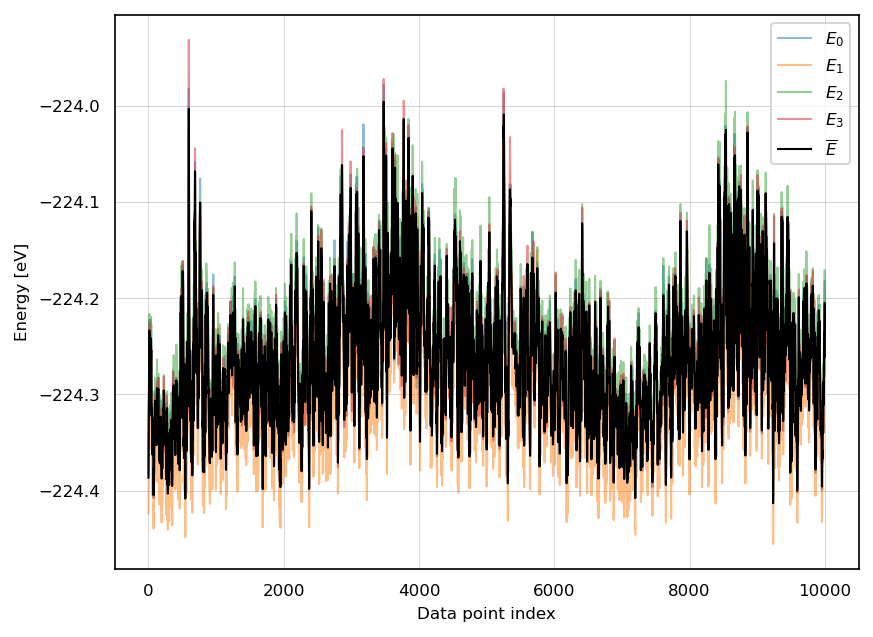

In [20]:
for n, e in enumerate(energies):
    plt.plot(e, label=rf'$E_{n:d}$', alpha=0.5)
plt.plot(avg_energy, label=r'$\overline{E}$', color='k')
plt.legend()
plt.xlabel('Data point index')
plt.ylabel('Energy [eV]');

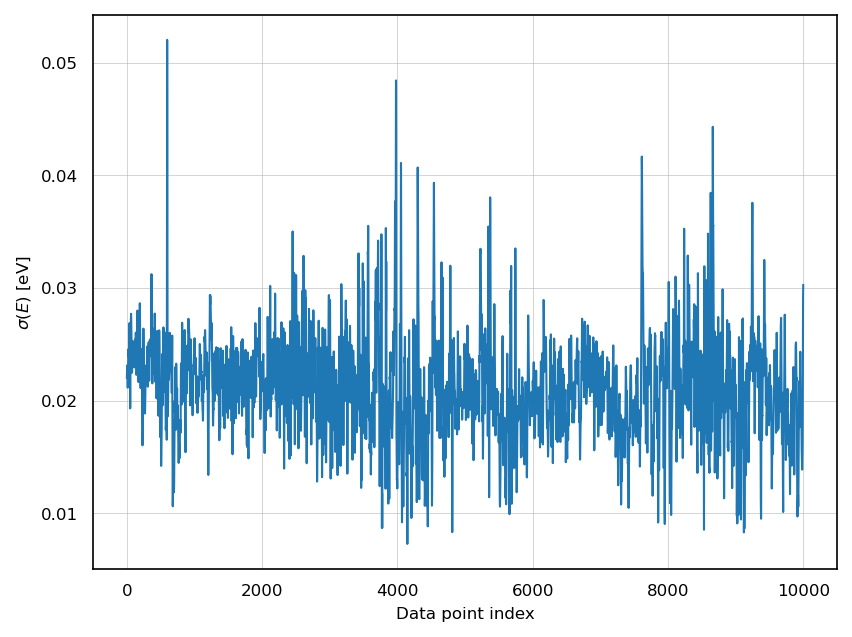

In [21]:
plt.plot(disagreement)
plt.xlabel('Data point index')
plt.ylabel(r'$\sigma(E)$ [eV]');

# Select relevant training data via Query by Committee (QbC)

Some text...

In [22]:
def run_qbc(fns_committee, fn_candidates, fn_train_init, n_iter, n_add_iter=10, recalculate_selected=False, calculator=None):
    """Main QbC loop."""
    # TODO: Add the possibility of attaching a ASE calculator for later when we need to address unlabeled data.
    # TODO: think about striding the candidates to make it more efficient
    # TODO: start from training set size 0?

    print(f'Starting QbC.')
    print(f'{n_iter:d} iterations will be done in total and {n_add_iter:d} will be added every iteration.')

    #os.makedirs('QbC', exist_ok=True)

    candidates = read(fn_candidates, index=':')
    training_set = []
    progress_disagreement = []
    for _ in tqdm(range(n_iter)):

        # predict disagreement on all candidates
        print(f'Predicting committee disagreement across the candidate pool.')
        energies = []
        for n, model in enumerate(fns_committee):
            fn_dump = f'eval_train_{n:02d}.extxyz'
            eval_mace(model, fn_candidates, fn_dump) # Explicit arguments!
            e = extxyz2energy(fn_dump)
            energies.append(e)
        energies = np.array(energies)
        disagreement = energies.std(axis=0)
        avg_disagreement_pool = disagreement.mean()

        # pick the `n_add_iter` highest-disagreement structures
        print(f'Picking {n_add_iter:d} new highest-disagreement data points.')
        idcs_selected = np.argsort(disagreement)[-n_add_iter:]
        print(idcs_selected)
        avg_disagreement_selected = (disagreement[idcs_selected]).mean()
        progress_disagreement.append(np.array([avg_disagreement_selected, avg_disagreement_pool]))
        # TODO: an ASE calculator will come here
        if recalculate_selected:
            assert calculator is not None, 'If a first-principles recalculation of training data is requested, a corresponding ASE calculator must be assigned.'
            print(f'Recalculating ab initio energies and forces for new data points.')
            for structure in candidates[idcs_selected]:
                structure.calc = calculator
                structure.get_potential_energy()
                structure.get_forces()
        #training_set.append([candidates[i] for i in idcs_selected])
        #candidates = np.delete(candidates, idcs_selected)
        # TODO: super ugly, make it better
        for i in idcs_selected:
            training_set.append(candidates[i])
        for i in idcs_selected:
            del candidates[i]

        # dump files with structures
        write('train-iter.extxyz', training_set, format='extxyz')
        write('candidates.extxyz', candidates, format='extxyz')

        # retrain the committee with the enriched training set
        print(f'Retraining committee.')
        # TODO: add multiprocessing
        # TODO: add model refinement
        for n in range(len(fns_committee)):
            train_mace(f"config/config.{n}.yml")

        # update the candidate file name
        fn_candidates = 'candidates.extxyz'

        print(f'Status at the end of this QbC iteration: Disagreement (pool) [eV]    Disagreement (selected) [eV]')
        print(f'                                         {avg_disagreement_pool:06f} {avg_disagreement_selected:06f}')

    # dump final training set
    write('train-final.extxyz', training_set, format='extxyz')
    np.savetxt('disagreement.txt', progress_disagreement)

In [23]:
# Define different values for each config
# TODO: make this simpler - the only thing we need to change is the name of the training extxyz file.
# TODO: implement retraining using the refinement workflow using `foundation_model`
os.makedirs('config', exist_ok=True)
seeds = np.random.randint(0, 2**32 - 1, size=n_committee, dtype=np.uint32)
for i in range(n_committee):
    filename = f"config/config.{i}.yml"
    name = f"mace.com={i}"
    
    config_text = f"""
# You can modify the following parameters
num_channels: 16
max_L: 0            # take it larger but not smaller
max_ell: 1          # take it larger but not smaller
correlation: 1      # take it larger but not smaller
num_interactions: 2 # take it larger but not smaller

# ... but you can also modify these ones
r_max: 4.0
batch_size: 4
max_num_epochs: 100

# But please, do not modify these parameters!
model: "MACE"
name: "{name}"
model_dir: "models"
log_dir: "log"
checkpoints_dir: "checkpoints"
results_dir: "results"
train_file: "train-iter.extxyz"
energy_key: "REF_energy"
forces_key: "REF_forces"
E0s: "average" # to be fixed
device: cpu
swa: true
seed: {seeds[i]}
restart_latest: True
"""

    with open(filename, "w") as f:
        f.write(config_text)

    print(f"Wrote {filename}")

Wrote config/config.0.yml
Wrote config/config.1.yml
Wrote config/config.2.yml
Wrote config/config.3.yml


In [24]:
fns_committee = [f'models/mace.n={n:d}.model' for n in range(n_committee)]

In [25]:
run_qbc(
    fns_committee=fns_committee,
    fn_candidates='structures/remaining.extxyz',
    fn_train_init='structures/init.train.extxyz',
    n_iter=5
);

Starting QbC.
5 iterations will be done in total and 10 will be added every iteration.


  0%|          | 0/5 [00:00<?, ?it/s]

Predicting committee disagreement across the candidate pool.
2025-05-16 10:09:51.041 INFO: Using CPU
2025-05-16 10:09:51.041 INFO: Using CPU
2025-05-16 10:09:51.041 INFO: Using CPU
2025-05-16 10:09:51.041 INFO: Using CPU
2025-05-16 10:09:51.041 INFO: Using CPU
2025-05-16 10:09:51.041 INFO: Using CPU
2025-05-16 10:09:58.743 INFO: Using CPU
2025-05-16 10:09:58.743 INFO: Using CPU
2025-05-16 10:09:58.743 INFO: Using CPU
2025-05-16 10:09:58.743 INFO: Using CPU
2025-05-16 10:09:58.743 INFO: Using CPU
2025-05-16 10:09:58.743 INFO: Using CPU
2025-05-16 10:10:06.719 INFO: Using CPU
2025-05-16 10:10:06.719 INFO: Using CPU
2025-05-16 10:10:06.719 INFO: Using CPU
2025-05-16 10:10:06.719 INFO: Using CPU
2025-05-16 10:10:06.719 INFO: Using CPU
2025-05-16 10:10:06.719 INFO: Using CPU
2025-05-16 10:10:14.252 INFO: Using CPU
2025-05-16 10:10:14.252 INFO: Using CPU
2025-05-16 10:10:14.252 INFO: Using CPU
2025-05-16 10:10:14.252 INFO: Using CPU
2025-05-16 10:10:14.252 INFO: Using CPU
2025-05-16 10:10:14

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The To

2025-05-16 10:10:23.003 INFO: Total number of parameters: 25472
2025-05-16 10:10:23.003 INFO: Total number of parameters: 25472
2025-05-16 10:10:23.003 INFO: Total number of parameters: 25472
2025-05-16 10:10:23.003 INFO: Total number of parameters: 25472
2025-05-16 10:10:23.003 INFO: Total number of parameters: 25472
2025-05-16 10:10:23.003 INFO: Total number of parameters: 25472
2025-05-16 10:10:23.003 INFO: Total number of parameters: 25472
2025-05-16 10:10:23.005 INFO: 
2025-05-16 10:10:23.005 INFO: 
2025-05-16 10:10:23.005 INFO: 
2025-05-16 10:10:23.005 INFO: 
2025-05-16 10:10:23.005 INFO: 
2025-05-16 10:10:23.005 INFO: 
2025-05-16 10:10:23.005 INFO: 
2025-05-16 10:10:23.006 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-16 10:10:23.006 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-16 10:10:23.006 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-16 10:10:23.006 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-16 10:10:23.006 INFO: =========

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezina

2025-05-16 10:10:23.070 WARNING: Cannot find checkpoint with tag 'mace.com=0_run-1225408308' in 'checkpoints'
2025-05-16 10:10:23.070 WARNING: Cannot find checkpoint with tag 'mace.com=0_run-1225408308' in 'checkpoints'
2025-05-16 10:10:23.070 WARNING: Cannot find checkpoint with tag 'mace.com=0_run-1225408308' in 'checkpoints'
2025-05-16 10:10:23.070 WARNING: Cannot find checkpoint with tag 'mace.com=0_run-1225408308' in 'checkpoints'
2025-05-16 10:10:23.070 WARNING: Cannot find checkpoint with tag 'mace.com=0_run-1225408308' in 'checkpoints'
2025-05-16 10:10:23.070 WARNING: Cannot find checkpoint with tag 'mace.com=0_run-1225408308' in 'checkpoints'
2025-05-16 10:10:23.070 WARNING: Cannot find checkpoint with tag 'mace.com=0_run-1225408308' in 'checkpoints'
2025-05-16 10:10:23.072 INFO: Using gradient clipping with tolerance=10.000
2025-05-16 10:10:23.072 INFO: Using gradient clipping with tolerance=10.000
2025-05-16 10:10:23.072 INFO: Using gradient clipping with tolerance=10.000
20

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


2025-05-16 10:10:23.307 INFO: Epoch 2: head: Default, loss=12.13615610, RMSE_E_per_atom=   35.76 meV, RMSE_F=  348.35 meV / A
2025-05-16 10:10:23.307 INFO: Epoch 2: head: Default, loss=12.13615610, RMSE_E_per_atom=   35.76 meV, RMSE_F=  348.35 meV / A
2025-05-16 10:10:23.307 INFO: Epoch 2: head: Default, loss=12.13615610, RMSE_E_per_atom=   35.76 meV, RMSE_F=  348.35 meV / A
2025-05-16 10:10:23.307 INFO: Epoch 2: head: Default, loss=12.13615610, RMSE_E_per_atom=   35.76 meV, RMSE_F=  348.35 meV / A
2025-05-16 10:10:23.307 INFO: Epoch 2: head: Default, loss=12.13615610, RMSE_E_per_atom=   35.76 meV, RMSE_F=  348.35 meV / A
2025-05-16 10:10:23.307 INFO: Epoch 2: head: Default, loss=12.13615610, RMSE_E_per_atom=   35.76 meV, RMSE_F=  348.35 meV / A
2025-05-16 10:10:23.307 INFO: Epoch 2: head: Default, loss=12.13615610, RMSE_E_per_atom=   35.76 meV, RMSE_F=  348.35 meV / A
2025-05-16 10:10:23.348 INFO: Epoch 3: head: Default, loss=15.16166878, RMSE_E_per_atom=   71.50 meV, RMSE_F=  389.31 

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),


2025-05-16 10:10:28.456 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:28.456 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:28.456 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:28.456 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:28.456 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:28.456 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:28.456 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:28.459 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-16 10:10:28.459 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-16 10:10:28.459 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-16 10:10:28.459 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-16 10:10:28.459 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-16 10:10:28

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),


2025-05-16 10:10:29.818 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:29.818 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:29.818 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:29.818 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:29.818 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:29.818 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:29.818 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:29.821 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-16 10:10:29.821 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-16 10:10:29.821 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-16 10:10:29.821 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-16 10:10:29.821 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-16 10:10:29

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


2025-05-16 10:10:30.727 INFO: Done
2025-05-16 10:10:30.727 INFO: Done
2025-05-16 10:10:30.727 INFO: Done
2025-05-16 10:10:30.727 INFO: Done
2025-05-16 10:10:30.727 INFO: Done
2025-05-16 10:10:30.727 INFO: Done
2025-05-16 10:10:30.727 INFO: Done
2025-05-16 10:10:30.733 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:10:30.733 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:10:30.733 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:10:30.733 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:10:30.733 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:10:30.733 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:10:30.733 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:10:30.733 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:10:30.736 INFO: MACE version: 0.3.13
2025-05-16 10:10:30.736 INFO: MACE version: 0.3.13
2025-05-16 10:10:30.736 INFO: MACE version: 0.3.13
2025-05-16 10:10:30.736 INFO: MACE

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The To

2025-05-16 10:10:31.147 INFO: Total number of parameters: 25472
2025-05-16 10:10:31.147 INFO: Total number of parameters: 25472
2025-05-16 10:10:31.147 INFO: Total number of parameters: 25472
2025-05-16 10:10:31.147 INFO: Total number of parameters: 25472
2025-05-16 10:10:31.147 INFO: Total number of parameters: 25472
2025-05-16 10:10:31.147 INFO: Total number of parameters: 25472
2025-05-16 10:10:31.147 INFO: Total number of parameters: 25472
2025-05-16 10:10:31.147 INFO: Total number of parameters: 25472
2025-05-16 10:10:31.149 INFO: 
2025-05-16 10:10:31.149 INFO: 
2025-05-16 10:10:31.149 INFO: 
2025-05-16 10:10:31.149 INFO: 
2025-05-16 10:10:31.149 INFO: 
2025-05-16 10:10:31.149 INFO: 
2025-05-16 10:10:31.149 INFO: 
2025-05-16 10:10:31.149 INFO: 
2025-05-16 10:10:31.149 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-16 10:10:31.149 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-16 10:10:31.149 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-16 10:10:3

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezina

2025-05-16 10:10:31.201 WARNING: Cannot find checkpoint with tag 'mace.com=1_run-1891961019' in 'checkpoints'
2025-05-16 10:10:31.201 WARNING: Cannot find checkpoint with tag 'mace.com=1_run-1891961019' in 'checkpoints'
2025-05-16 10:10:31.201 WARNING: Cannot find checkpoint with tag 'mace.com=1_run-1891961019' in 'checkpoints'
2025-05-16 10:10:31.201 WARNING: Cannot find checkpoint with tag 'mace.com=1_run-1891961019' in 'checkpoints'
2025-05-16 10:10:31.201 WARNING: Cannot find checkpoint with tag 'mace.com=1_run-1891961019' in 'checkpoints'
2025-05-16 10:10:31.201 WARNING: Cannot find checkpoint with tag 'mace.com=1_run-1891961019' in 'checkpoints'
2025-05-16 10:10:31.201 WARNING: Cannot find checkpoint with tag 'mace.com=1_run-1891961019' in 'checkpoints'
2025-05-16 10:10:31.201 WARNING: Cannot find checkpoint with tag 'mace.com=1_run-1891961019' in 'checkpoints'
2025-05-16 10:10:31.203 INFO: Using gradient clipping with tolerance=10.000
2025-05-16 10:10:31.203 INFO: Using gradient

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


2025-05-16 10:10:31.450 INFO: Epoch 3: head: Default, loss=129.11526413, RMSE_E_per_atom=  136.26 meV, RMSE_F= 1136.21 meV / A
2025-05-16 10:10:31.450 INFO: Epoch 3: head: Default, loss=129.11526413, RMSE_E_per_atom=  136.26 meV, RMSE_F= 1136.21 meV / A
2025-05-16 10:10:31.450 INFO: Epoch 3: head: Default, loss=129.11526413, RMSE_E_per_atom=  136.26 meV, RMSE_F= 1136.21 meV / A
2025-05-16 10:10:31.450 INFO: Epoch 3: head: Default, loss=129.11526413, RMSE_E_per_atom=  136.26 meV, RMSE_F= 1136.21 meV / A
2025-05-16 10:10:31.450 INFO: Epoch 3: head: Default, loss=129.11526413, RMSE_E_per_atom=  136.26 meV, RMSE_F= 1136.21 meV / A
2025-05-16 10:10:31.450 INFO: Epoch 3: head: Default, loss=129.11526413, RMSE_E_per_atom=  136.26 meV, RMSE_F= 1136.21 meV / A
2025-05-16 10:10:31.450 INFO: Epoch 3: head: Default, loss=129.11526413, RMSE_E_per_atom=  136.26 meV, RMSE_F= 1136.21 meV / A
2025-05-16 10:10:31.450 INFO: Epoch 3: head: Default, loss=129.11526413, RMSE_E_per_atom=  136.26 meV, RMSE_F= 

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),


2025-05-16 10:10:36.960 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:36.960 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:36.960 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:36.960 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:36.960 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:36.960 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:36.960 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:36.960 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:36.965 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-16 10:10:36.965 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-16 10:10:36.965 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-16 10:10:36.965 INFO: Skipping evaluation for heads: ['pt_head']
2025

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),


2025-05-16 10:10:38.786 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:38.786 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:38.786 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:38.786 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:38.786 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:38.786 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:38.786 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:38.786 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:38.789 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-16 10:10:38.789 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-16 10:10:38.789 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-16 10:10:38.789 INFO: Skipping evaluation for heads: ['pt_head']
2025

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


2025-05-16 10:10:39.766 INFO: Done
2025-05-16 10:10:39.766 INFO: Done
2025-05-16 10:10:39.766 INFO: Done
2025-05-16 10:10:39.766 INFO: Done
2025-05-16 10:10:39.766 INFO: Done
2025-05-16 10:10:39.766 INFO: Done
2025-05-16 10:10:39.766 INFO: Done
2025-05-16 10:10:39.766 INFO: Done
2025-05-16 10:10:39.772 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:10:39.772 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:10:39.772 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:10:39.772 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:10:39.772 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:10:39.772 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:10:39.772 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:10:39.772 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:10:39.772 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:10:39.774 INFO: MACE version: 0.3.13
2025-05-16 10:10:39.774 INFO: 

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The To

2025-05-16 10:10:40.266 INFO: Total number of parameters: 25472
2025-05-16 10:10:40.266 INFO: Total number of parameters: 25472
2025-05-16 10:10:40.266 INFO: Total number of parameters: 25472
2025-05-16 10:10:40.266 INFO: Total number of parameters: 25472
2025-05-16 10:10:40.266 INFO: Total number of parameters: 25472
2025-05-16 10:10:40.266 INFO: Total number of parameters: 25472
2025-05-16 10:10:40.266 INFO: Total number of parameters: 25472
2025-05-16 10:10:40.266 INFO: Total number of parameters: 25472
2025-05-16 10:10:40.266 INFO: Total number of parameters: 25472
2025-05-16 10:10:40.268 INFO: 
2025-05-16 10:10:40.268 INFO: 
2025-05-16 10:10:40.268 INFO: 
2025-05-16 10:10:40.268 INFO: 
2025-05-16 10:10:40.268 INFO: 
2025-05-16 10:10:40.268 INFO: 
2025-05-16 10:10:40.268 INFO: 
2025-05-16 10:10:40.268 INFO: 
2025-05-16 10:10:40.268 INFO: 
2025-05-16 10:10:40.270 INFO: ===========OPTIMIZER INFORMATION===========
2025-05-16 10:10:40.270 INFO: ===========OPTIMIZER INFORMATION=========

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


2025-05-16 10:10:40.472 INFO: Epoch 0: head: Default, loss=50.17451703, RMSE_E_per_atom=   26.06 meV, RMSE_F=  708.33 meV / A
2025-05-16 10:10:40.472 INFO: Epoch 0: head: Default, loss=50.17451703, RMSE_E_per_atom=   26.06 meV, RMSE_F=  708.33 meV / A
2025-05-16 10:10:40.472 INFO: Epoch 0: head: Default, loss=50.17451703, RMSE_E_per_atom=   26.06 meV, RMSE_F=  708.33 meV / A
2025-05-16 10:10:40.472 INFO: Epoch 0: head: Default, loss=50.17451703, RMSE_E_per_atom=   26.06 meV, RMSE_F=  708.33 meV / A
2025-05-16 10:10:40.472 INFO: Epoch 0: head: Default, loss=50.17451703, RMSE_E_per_atom=   26.06 meV, RMSE_F=  708.33 meV / A
2025-05-16 10:10:40.472 INFO: Epoch 0: head: Default, loss=50.17451703, RMSE_E_per_atom=   26.06 meV, RMSE_F=  708.33 meV / A
2025-05-16 10:10:40.472 INFO: Epoch 0: head: Default, loss=50.17451703, RMSE_E_per_atom=   26.06 meV, RMSE_F=  708.33 meV / A
2025-05-16 10:10:40.472 INFO: Epoch 0: head: Default, loss=50.17451703, RMSE_E_per_atom=   26.06 meV, RMSE_F=  708.33 

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),


2025-05-16 10:10:46.220 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:46.220 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:46.220 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:46.220 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:46.220 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:46.220 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:46.220 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:46.220 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:46.220 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:46.223 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-16 10:10:46.223 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-16 10:10:46.223 INFO: Skipping evaluation for heads: [

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),


2025-05-16 10:10:47.644 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:47.644 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:47.644 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:47.644 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:47.644 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:47.644 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:47.644 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:47.644 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:47.644 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:47.647 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-16 10:10:47.647 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-16 10:10:47.647 INFO: Skipping evaluation for heads: [

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


2025-05-16 10:10:48.685 INFO: Done
2025-05-16 10:10:48.685 INFO: Done
2025-05-16 10:10:48.685 INFO: Done
2025-05-16 10:10:48.685 INFO: Done
2025-05-16 10:10:48.685 INFO: Done
2025-05-16 10:10:48.685 INFO: Done
2025-05-16 10:10:48.685 INFO: Done
2025-05-16 10:10:48.685 INFO: Done
2025-05-16 10:10:48.685 INFO: Done
2025-05-16 10:10:48.690 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:10:48.690 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:10:48.690 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:10:48.690 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:10:48.690 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:10:48.690 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:10:48.690 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:10:48.690 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:10:48.690 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:10:48.690 INFO: ===========VERIF

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The To

2025-05-16 10:10:49.170 INFO: Total number of parameters: 25472
2025-05-16 10:10:49.170 INFO: Total number of parameters: 25472
2025-05-16 10:10:49.170 INFO: Total number of parameters: 25472
2025-05-16 10:10:49.170 INFO: Total number of parameters: 25472
2025-05-16 10:10:49.170 INFO: Total number of parameters: 25472
2025-05-16 10:10:49.170 INFO: Total number of parameters: 25472
2025-05-16 10:10:49.170 INFO: Total number of parameters: 25472
2025-05-16 10:10:49.170 INFO: Total number of parameters: 25472
2025-05-16 10:10:49.170 INFO: Total number of parameters: 25472
2025-05-16 10:10:49.170 INFO: Total number of parameters: 25472
2025-05-16 10:10:49.172 INFO: 
2025-05-16 10:10:49.172 INFO: 
2025-05-16 10:10:49.172 INFO: 
2025-05-16 10:10:49.172 INFO: 
2025-05-16 10:10:49.172 INFO: 
2025-05-16 10:10:49.172 INFO: 
2025-05-16 10:10:49.172 INFO: 
2025-05-16 10:10:49.172 INFO: 
2025-05-16 10:10:49.172 INFO: 
2025-05-16 10:10:49.172 INFO: 
2025-05-16 10:10:49.173 INFO: ===========OPTIMIZER

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


2025-05-16 10:10:49.380 INFO: Epoch 0: head: Default, loss=18.10044902, RMSE_E_per_atom=   15.30 meV, RMSE_F=  425.44 meV / A
2025-05-16 10:10:49.380 INFO: Epoch 0: head: Default, loss=18.10044902, RMSE_E_per_atom=   15.30 meV, RMSE_F=  425.44 meV / A
2025-05-16 10:10:49.380 INFO: Epoch 0: head: Default, loss=18.10044902, RMSE_E_per_atom=   15.30 meV, RMSE_F=  425.44 meV / A
2025-05-16 10:10:49.380 INFO: Epoch 0: head: Default, loss=18.10044902, RMSE_E_per_atom=   15.30 meV, RMSE_F=  425.44 meV / A
2025-05-16 10:10:49.380 INFO: Epoch 0: head: Default, loss=18.10044902, RMSE_E_per_atom=   15.30 meV, RMSE_F=  425.44 meV / A
2025-05-16 10:10:49.380 INFO: Epoch 0: head: Default, loss=18.10044902, RMSE_E_per_atom=   15.30 meV, RMSE_F=  425.44 meV / A
2025-05-16 10:10:49.380 INFO: Epoch 0: head: Default, loss=18.10044902, RMSE_E_per_atom=   15.30 meV, RMSE_F=  425.44 meV / A
2025-05-16 10:10:49.380 INFO: Epoch 0: head: Default, loss=18.10044902, RMSE_E_per_atom=   15.30 meV, RMSE_F=  425.44 

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),


2025-05-16 10:10:55.124 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:55.124 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:55.124 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:55.124 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:55.124 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:55.124 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:55.124 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:55.124 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:55.124 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:55.124 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:55.128 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-16 10:10:55.128 INFO: Skipping evaluati

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),


2025-05-16 10:10:57.063 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:57.063 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:57.063 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:57.063 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:57.063 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:57.063 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:57.063 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:57.063 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:57.063 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:57.063 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:10:57.067 INFO: Skipping evaluation for heads: ['pt_head']
2025-05-16 10:10:57.067 INFO: Skipping evaluati

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


2025-05-16 10:10:58.119 INFO: Done
2025-05-16 10:10:58.119 INFO: Done
2025-05-16 10:10:58.119 INFO: Done
2025-05-16 10:10:58.119 INFO: Done
2025-05-16 10:10:58.119 INFO: Done
2025-05-16 10:10:58.119 INFO: Done
2025-05-16 10:10:58.119 INFO: Done
2025-05-16 10:10:58.119 INFO: Done
2025-05-16 10:10:58.119 INFO: Done
2025-05-16 10:10:58.119 INFO: Done
Status at the end of this QbC iteration: Disagreement (pool) [eV]    Disagreement (selected) [eV]
                                         0.021090 0.047675
Predicting committee disagreement across the candidate pool.
2025-05-16 10:10:58.123 INFO: Using CPU
2025-05-16 10:10:58.123 INFO: Using CPU
2025-05-16 10:10:58.123 INFO: Using CPU
2025-05-16 10:10:58.123 INFO: Using CPU
2025-05-16 10:10:58.123 INFO: Using CPU
2025-05-16 10:10:58.123 INFO: Using CPU
2025-05-16 10:10:58.123 INFO: Using CPU
2025-05-16 10:10:58.123 INFO: Using CPU
2025-05-16 10:10:58.123 INFO: Using CPU
2025-05-16 10:10:58.123 INFO: Using CPU


/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/cli/eval_configs.py:78: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  model = torch.load(f=args.model, map_location=args.device)
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/serialization.py:1488: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn(


2025-05-16 10:11:06.543 INFO: Using CPU
2025-05-16 10:11:06.543 INFO: Using CPU
2025-05-16 10:11:06.543 INFO: Using CPU
2025-05-16 10:11:06.543 INFO: Using CPU
2025-05-16 10:11:06.543 INFO: Using CPU
2025-05-16 10:11:06.543 INFO: Using CPU
2025-05-16 10:11:06.543 INFO: Using CPU
2025-05-16 10:11:06.543 INFO: Using CPU
2025-05-16 10:11:06.543 INFO: Using CPU
2025-05-16 10:11:06.543 INFO: Using CPU
2025-05-16 10:11:14.145 INFO: Using CPU
2025-05-16 10:11:14.145 INFO: Using CPU
2025-05-16 10:11:14.145 INFO: Using CPU
2025-05-16 10:11:14.145 INFO: Using CPU
2025-05-16 10:11:14.145 INFO: Using CPU
2025-05-16 10:11:14.145 INFO: Using CPU
2025-05-16 10:11:14.145 INFO: Using CPU
2025-05-16 10:11:14.145 INFO: Using CPU
2025-05-16 10:11:14.145 INFO: Using CPU
2025-05-16 10:11:14.145 INFO: Using CPU
2025-05-16 10:11:21.849 INFO: Using CPU
2025-05-16 10:11:21.849 INFO: Using CPU
2025-05-16 10:11:21.849 INFO: Using CPU
2025-05-16 10:11:21.849 INFO: Using CPU
2025-05-16 10:11:21.849 INFO: Using CPU


/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The To

2025-05-16 10:11:31.461 INFO: Total number of parameters: 25472
2025-05-16 10:11:31.461 INFO: Total number of parameters: 25472
2025-05-16 10:11:31.461 INFO: Total number of parameters: 25472
2025-05-16 10:11:31.461 INFO: Total number of parameters: 25472
2025-05-16 10:11:31.461 INFO: Total number of parameters: 25472
2025-05-16 10:11:31.461 INFO: Total number of parameters: 25472
2025-05-16 10:11:31.461 INFO: Total number of parameters: 25472
2025-05-16 10:11:31.461 INFO: Total number of parameters: 25472
2025-05-16 10:11:31.461 INFO: Total number of parameters: 25472
2025-05-16 10:11:31.461 INFO: Total number of parameters: 25472
2025-05-16 10:11:31.461 INFO: Total number of parameters: 25472
2025-05-16 10:11:31.463 INFO: 
2025-05-16 10:11:31.463 INFO: 
2025-05-16 10:11:31.463 INFO: 
2025-05-16 10:11:31.463 INFO: 
2025-05-16 10:11:31.463 INFO: 
2025-05-16 10:11:31.463 INFO: 
2025-05-16 10:11:31.463 INFO: 
2025-05-16 10:11:31.463 INFO: 
2025-05-16 10:11:31.463 INFO: 
2025-05-16 10:11:

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezina

2025-05-16 10:11:31.477 INFO: Stage Two (after 75 epochs) with loss function: WeightedEnergyForcesLoss(energy_weight=1000.000, forces_weight=100.000), with energy weight : 1000.0, forces weight : 100.0 and learning rate : 0.001
2025-05-16 10:11:31.477 INFO: Stage Two (after 75 epochs) with loss function: WeightedEnergyForcesLoss(energy_weight=1000.000, forces_weight=100.000), with energy weight : 1000.0, forces weight : 100.0 and learning rate : 0.001
2025-05-16 10:11:31.477 INFO: Stage Two (after 75 epochs) with loss function: WeightedEnergyForcesLoss(energy_weight=1000.000, forces_weight=100.000), with energy weight : 1000.0, forces weight : 100.0 and learning rate : 0.001
2025-05-16 10:11:31.477 INFO: Stage Two (after 75 epochs) with loss function: WeightedEnergyForcesLoss(energy_weight=1000.000, forces_weight=100.000), with energy weight : 1000.0, forces weight : 100.0 and learning rate : 0.001
2025-05-16 10:11:31.477 INFO: Stage Two (after 75 epochs) with loss function: WeightedEn

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


2025-05-16 10:11:31.800 INFO: Epoch 98: head: Default, loss=11.86941345, RMSE_E_per_atom=   72.50 meV, RMSE_F=  429.91 meV / A
2025-05-16 10:11:31.800 INFO: Epoch 98: head: Default, loss=11.86941345, RMSE_E_per_atom=   72.50 meV, RMSE_F=  429.91 meV / A
2025-05-16 10:11:31.800 INFO: Epoch 98: head: Default, loss=11.86941345, RMSE_E_per_atom=   72.50 meV, RMSE_F=  429.91 meV / A
2025-05-16 10:11:31.800 INFO: Epoch 98: head: Default, loss=11.86941345, RMSE_E_per_atom=   72.50 meV, RMSE_F=  429.91 meV / A
2025-05-16 10:11:31.800 INFO: Epoch 98: head: Default, loss=11.86941345, RMSE_E_per_atom=   72.50 meV, RMSE_F=  429.91 meV / A
2025-05-16 10:11:31.800 INFO: Epoch 98: head: Default, loss=11.86941345, RMSE_E_per_atom=   72.50 meV, RMSE_F=  429.91 meV / A
2025-05-16 10:11:31.800 INFO: Epoch 98: head: Default, loss=11.86941345, RMSE_E_per_atom=   72.50 meV, RMSE_F=  429.91 meV / A
2025-05-16 10:11:31.800 INFO: Epoch 98: head: Default, loss=11.86941345, RMSE_E_per_atom=   72.50 meV, RMSE_F= 

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),


2025-05-16 10:11:33.796 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:11:33.796 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:11:33.796 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:11:33.796 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:11:33.796 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:11:33.796 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:11:33.796 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:11:33.796 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:11:33.796 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:11:33.796 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:11:33.796 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:11:33.801 INFO: Sk

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


2025-05-16 10:11:34.866 INFO: Done
2025-05-16 10:11:34.866 INFO: Done
2025-05-16 10:11:34.866 INFO: Done
2025-05-16 10:11:34.866 INFO: Done
2025-05-16 10:11:34.866 INFO: Done
2025-05-16 10:11:34.866 INFO: Done
2025-05-16 10:11:34.866 INFO: Done
2025-05-16 10:11:34.866 INFO: Done
2025-05-16 10:11:34.866 INFO: Done
2025-05-16 10:11:34.866 INFO: Done
2025-05-16 10:11:34.866 INFO: Done
2025-05-16 10:11:34.872 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:11:34.872 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:11:34.872 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:11:34.872 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:11:34.872 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:11:34.872 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:11:34.872 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:11:34.872 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:11:34.872 INFO: ===========VERIFY

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The To

2025-05-16 10:11:35.301 INFO: Total number of parameters: 25472
2025-05-16 10:11:35.301 INFO: Total number of parameters: 25472
2025-05-16 10:11:35.301 INFO: Total number of parameters: 25472
2025-05-16 10:11:35.301 INFO: Total number of parameters: 25472
2025-05-16 10:11:35.301 INFO: Total number of parameters: 25472
2025-05-16 10:11:35.301 INFO: Total number of parameters: 25472
2025-05-16 10:11:35.301 INFO: Total number of parameters: 25472
2025-05-16 10:11:35.301 INFO: Total number of parameters: 25472
2025-05-16 10:11:35.301 INFO: Total number of parameters: 25472
2025-05-16 10:11:35.301 INFO: Total number of parameters: 25472
2025-05-16 10:11:35.301 INFO: Total number of parameters: 25472
2025-05-16 10:11:35.301 INFO: Total number of parameters: 25472
2025-05-16 10:11:35.303 INFO: 
2025-05-16 10:11:35.303 INFO: 
2025-05-16 10:11:35.303 INFO: 
2025-05-16 10:11:35.303 INFO: 
2025-05-16 10:11:35.303 INFO: 
2025-05-16 10:11:35.303 INFO: 
2025-05-16 10:11:35.303 INFO: 
2025-05-16 10:1

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezina

2025-05-16 10:11:35.367 INFO: Loading checkpoint: checkpoints/mace.com=1_run-1891961019_epoch-99_swa.pt
2025-05-16 10:11:35.367 INFO: Loading checkpoint: checkpoints/mace.com=1_run-1891961019_epoch-99_swa.pt
2025-05-16 10:11:35.367 INFO: Loading checkpoint: checkpoints/mace.com=1_run-1891961019_epoch-99_swa.pt
2025-05-16 10:11:35.367 INFO: Loading checkpoint: checkpoints/mace.com=1_run-1891961019_epoch-99_swa.pt
2025-05-16 10:11:35.367 INFO: Loading checkpoint: checkpoints/mace.com=1_run-1891961019_epoch-99_swa.pt
2025-05-16 10:11:35.367 INFO: Loading checkpoint: checkpoints/mace.com=1_run-1891961019_epoch-99_swa.pt
2025-05-16 10:11:35.367 INFO: Loading checkpoint: checkpoints/mace.com=1_run-1891961019_epoch-99_swa.pt
2025-05-16 10:11:35.367 INFO: Loading checkpoint: checkpoints/mace.com=1_run-1891961019_epoch-99_swa.pt
2025-05-16 10:11:35.367 INFO: Loading checkpoint: checkpoints/mace.com=1_run-1891961019_epoch-99_swa.pt
2025-05-16 10:11:35.367 INFO: Loading checkpoint: checkpoints/ma

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


2025-05-16 10:11:35.569 INFO: 
2025-05-16 10:11:35.569 INFO: 
2025-05-16 10:11:35.569 INFO: 
2025-05-16 10:11:35.569 INFO: 
2025-05-16 10:11:35.569 INFO: 
2025-05-16 10:11:35.569 INFO: 
2025-05-16 10:11:35.569 INFO: 
2025-05-16 10:11:35.569 INFO: 
2025-05-16 10:11:35.569 INFO: 
2025-05-16 10:11:35.569 INFO: 
2025-05-16 10:11:35.571 INFO: ===========RESULTS===========
2025-05-16 10:11:35.571 INFO: ===========RESULTS===========
2025-05-16 10:11:35.571 INFO: ===========RESULTS===========
2025-05-16 10:11:35.571 INFO: ===========RESULTS===========
2025-05-16 10:11:35.571 INFO: ===========RESULTS===========
2025-05-16 10:11:35.571 INFO: ===========RESULTS===========
2025-05-16 10:11:35.571 INFO: ===========RESULTS===========
2025-05-16 10:11:35.571 INFO: ===========RESULTS===========
2025-05-16 10:11:35.571 INFO: ===========RESULTS===========
2025-05-16 10:11:35.571 INFO: ===========RESULTS===========
2025-05-16 10:11:35.571 INFO: ===========RESULTS===========
2025-05-16 10:11:35.571 INFO: 

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),


2025-05-16 10:11:37.429 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:11:37.429 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:11:37.429 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:11:37.429 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:11:37.429 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:11:37.429 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:11:37.429 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:11:37.429 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:11:37.429 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:11:37.429 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:11:37.429 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:11:37.429 INFO: Co

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


2025-05-16 10:11:38.436 INFO: Done
2025-05-16 10:11:38.436 INFO: Done
2025-05-16 10:11:38.436 INFO: Done
2025-05-16 10:11:38.436 INFO: Done
2025-05-16 10:11:38.436 INFO: Done
2025-05-16 10:11:38.436 INFO: Done
2025-05-16 10:11:38.436 INFO: Done
2025-05-16 10:11:38.436 INFO: Done
2025-05-16 10:11:38.436 INFO: Done
2025-05-16 10:11:38.436 INFO: Done
2025-05-16 10:11:38.436 INFO: Done
2025-05-16 10:11:38.436 INFO: Done
2025-05-16 10:11:38.442 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:11:38.442 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:11:38.442 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:11:38.442 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:11:38.442 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:11:38.442 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:11:38.442 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:11:38.442 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 1

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The To

2025-05-16 10:11:38.883 INFO: Total number of parameters: 25472
2025-05-16 10:11:38.883 INFO: Total number of parameters: 25472
2025-05-16 10:11:38.883 INFO: Total number of parameters: 25472
2025-05-16 10:11:38.883 INFO: Total number of parameters: 25472
2025-05-16 10:11:38.883 INFO: Total number of parameters: 25472
2025-05-16 10:11:38.883 INFO: Total number of parameters: 25472
2025-05-16 10:11:38.883 INFO: Total number of parameters: 25472
2025-05-16 10:11:38.883 INFO: Total number of parameters: 25472
2025-05-16 10:11:38.883 INFO: Total number of parameters: 25472
2025-05-16 10:11:38.883 INFO: Total number of parameters: 25472
2025-05-16 10:11:38.883 INFO: Total number of parameters: 25472
2025-05-16 10:11:38.883 INFO: Total number of parameters: 25472
2025-05-16 10:11:38.883 INFO: Total number of parameters: 25472
2025-05-16 10:11:38.886 INFO: 
2025-05-16 10:11:38.886 INFO: 
2025-05-16 10:11:38.886 INFO: 
2025-05-16 10:11:38.886 INFO: 
2025-05-16 10:11:38.886 INFO: 
2025-05-16 10

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezina

2025-05-16 10:11:38.948 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2878628072_epoch-99_swa.pt
2025-05-16 10:11:38.948 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2878628072_epoch-99_swa.pt
2025-05-16 10:11:38.948 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2878628072_epoch-99_swa.pt
2025-05-16 10:11:38.948 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2878628072_epoch-99_swa.pt
2025-05-16 10:11:38.948 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2878628072_epoch-99_swa.pt
2025-05-16 10:11:38.948 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2878628072_epoch-99_swa.pt
2025-05-16 10:11:38.948 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2878628072_epoch-99_swa.pt
2025-05-16 10:11:38.948 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2878628072_epoch-99_swa.pt
2025-05-16 10:11:38.948 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2878628072_epoch-99_swa.pt
2025-05-16 10:11:38.948 INFO: Loading checkpoint: checkpoints/ma

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


2025-05-16 10:11:39.151 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2878628072_epoch-67.pt
2025-05-16 10:11:39.151 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2878628072_epoch-67.pt
2025-05-16 10:11:39.151 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2878628072_epoch-67.pt
2025-05-16 10:11:39.151 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2878628072_epoch-67.pt
2025-05-16 10:11:39.151 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2878628072_epoch-67.pt
2025-05-16 10:11:39.151 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2878628072_epoch-67.pt
2025-05-16 10:11:39.151 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2878628072_epoch-67.pt
2025-05-16 10:11:39.151 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2878628072_epoch-67.pt
2025-05-16 10:11:39.151 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2878628072_epoch-67.pt
2025-05-16 10:11:39.151 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2878628072_epoch-67.pt


/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),


2025-05-16 10:11:41.510 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:11:41.510 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:11:41.510 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:11:41.510 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:11:41.510 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:11:41.510 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:11:41.510 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:11:41.510 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:11:41.510 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:11:41.510 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:11:41.510 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:11:41.510 INFO: Co

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


2025-05-16 10:11:42.473 INFO: Done
2025-05-16 10:11:42.473 INFO: Done
2025-05-16 10:11:42.473 INFO: Done
2025-05-16 10:11:42.473 INFO: Done
2025-05-16 10:11:42.473 INFO: Done
2025-05-16 10:11:42.473 INFO: Done
2025-05-16 10:11:42.473 INFO: Done
2025-05-16 10:11:42.473 INFO: Done
2025-05-16 10:11:42.473 INFO: Done
2025-05-16 10:11:42.473 INFO: Done
2025-05-16 10:11:42.473 INFO: Done
2025-05-16 10:11:42.473 INFO: Done
2025-05-16 10:11:42.473 INFO: Done
2025-05-16 10:11:42.479 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:11:42.479 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:11:42.479 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:11:42.479 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:11:42.479 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:11:42.479 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:11:42.479 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:11:42.479 INFO: ===========VERIFYI

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The To

2025-05-16 10:11:42.904 INFO: Total number of parameters: 25472
2025-05-16 10:11:42.904 INFO: Total number of parameters: 25472
2025-05-16 10:11:42.904 INFO: Total number of parameters: 25472
2025-05-16 10:11:42.904 INFO: Total number of parameters: 25472
2025-05-16 10:11:42.904 INFO: Total number of parameters: 25472
2025-05-16 10:11:42.904 INFO: Total number of parameters: 25472
2025-05-16 10:11:42.904 INFO: Total number of parameters: 25472
2025-05-16 10:11:42.904 INFO: Total number of parameters: 25472
2025-05-16 10:11:42.904 INFO: Total number of parameters: 25472
2025-05-16 10:11:42.904 INFO: Total number of parameters: 25472
2025-05-16 10:11:42.904 INFO: Total number of parameters: 25472
2025-05-16 10:11:42.904 INFO: Total number of parameters: 25472
2025-05-16 10:11:42.904 INFO: Total number of parameters: 25472
2025-05-16 10:11:42.904 INFO: Total number of parameters: 25472
2025-05-16 10:11:42.907 INFO: 
2025-05-16 10:11:42.907 INFO: 
2025-05-16 10:11:42.907 INFO: 
2025-05-16 

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezina

2025-05-16 10:11:42.963 INFO: Loading checkpoint: checkpoints/mace.com=3_run-2391317916_epoch-99_swa.pt
2025-05-16 10:11:42.963 INFO: Loading checkpoint: checkpoints/mace.com=3_run-2391317916_epoch-99_swa.pt
2025-05-16 10:11:42.963 INFO: Loading checkpoint: checkpoints/mace.com=3_run-2391317916_epoch-99_swa.pt
2025-05-16 10:11:42.963 INFO: Loading checkpoint: checkpoints/mace.com=3_run-2391317916_epoch-99_swa.pt
2025-05-16 10:11:42.963 INFO: Loading checkpoint: checkpoints/mace.com=3_run-2391317916_epoch-99_swa.pt
2025-05-16 10:11:42.963 INFO: Loading checkpoint: checkpoints/mace.com=3_run-2391317916_epoch-99_swa.pt
2025-05-16 10:11:42.963 INFO: Loading checkpoint: checkpoints/mace.com=3_run-2391317916_epoch-99_swa.pt
2025-05-16 10:11:42.963 INFO: Loading checkpoint: checkpoints/mace.com=3_run-2391317916_epoch-99_swa.pt
2025-05-16 10:11:42.963 INFO: Loading checkpoint: checkpoints/mace.com=3_run-2391317916_epoch-99_swa.pt
2025-05-16 10:11:42.963 INFO: Loading checkpoint: checkpoints/ma

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


2025-05-16 10:11:43.226 INFO: Compiling model, saving metadata to models/mace.com=3_compiled.model
2025-05-16 10:11:43.226 INFO: Compiling model, saving metadata to models/mace.com=3_compiled.model
2025-05-16 10:11:43.226 INFO: Compiling model, saving metadata to models/mace.com=3_compiled.model
2025-05-16 10:11:43.226 INFO: Compiling model, saving metadata to models/mace.com=3_compiled.model
2025-05-16 10:11:43.226 INFO: Compiling model, saving metadata to models/mace.com=3_compiled.model
2025-05-16 10:11:43.226 INFO: Compiling model, saving metadata to models/mace.com=3_compiled.model
2025-05-16 10:11:43.226 INFO: Compiling model, saving metadata to models/mace.com=3_compiled.model
2025-05-16 10:11:43.226 INFO: Compiling model, saving metadata to models/mace.com=3_compiled.model
2025-05-16 10:11:43.226 INFO: Compiling model, saving metadata to models/mace.com=3_compiled.model
2025-05-16 10:11:43.226 INFO: Compiling model, saving metadata to models/mace.com=3_compiled.model
2025-05-16

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),


2025-05-16 10:11:44.940 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:11:44.940 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:11:44.940 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:11:44.940 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:11:44.940 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:11:44.940 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:11:44.940 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:11:44.940 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:11:44.940 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:11:44.940 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:11:44.940 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:11:44.940 INFO: Co

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


2025-05-16 10:11:45.988 INFO: Done
2025-05-16 10:11:45.988 INFO: Done
2025-05-16 10:11:45.988 INFO: Done
2025-05-16 10:11:45.988 INFO: Done
2025-05-16 10:11:45.988 INFO: Done
2025-05-16 10:11:45.988 INFO: Done
2025-05-16 10:11:45.988 INFO: Done
2025-05-16 10:11:45.988 INFO: Done
2025-05-16 10:11:45.988 INFO: Done
2025-05-16 10:11:45.988 INFO: Done
2025-05-16 10:11:45.988 INFO: Done
2025-05-16 10:11:45.988 INFO: Done
2025-05-16 10:11:45.988 INFO: Done
2025-05-16 10:11:45.988 INFO: Done
Status at the end of this QbC iteration: Disagreement (pool) [eV]    Disagreement (selected) [eV]
                                         0.021071 0.045074
Predicting committee disagreement across the candidate pool.
2025-05-16 10:11:45.991 INFO: Using CPU
2025-05-16 10:11:45.991 INFO: Using CPU
2025-05-16 10:11:45.991 INFO: Using CPU
2025-05-16 10:11:45.991 INFO: Using CPU
2025-05-16 10:11:45.991 INFO: Using CPU
2025-05-16 10:11:45.991 INFO: Using CPU
2025-05-16 10:11:45.991 INFO: Using CPU
2025-05-16 1

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/cli/eval_configs.py:78: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  model = torch.load(f=args.model, map_location=args.device)
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/serialization.py:1488: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn(


2025-05-16 10:11:53.713 INFO: Using CPU
2025-05-16 10:11:53.713 INFO: Using CPU
2025-05-16 10:11:53.713 INFO: Using CPU
2025-05-16 10:11:53.713 INFO: Using CPU
2025-05-16 10:11:53.713 INFO: Using CPU
2025-05-16 10:11:53.713 INFO: Using CPU
2025-05-16 10:11:53.713 INFO: Using CPU
2025-05-16 10:11:53.713 INFO: Using CPU
2025-05-16 10:11:53.713 INFO: Using CPU
2025-05-16 10:11:53.713 INFO: Using CPU
2025-05-16 10:11:53.713 INFO: Using CPU
2025-05-16 10:11:53.713 INFO: Using CPU
2025-05-16 10:11:53.713 INFO: Using CPU
2025-05-16 10:11:53.713 INFO: Using CPU
2025-05-16 10:12:01.394 INFO: Using CPU
2025-05-16 10:12:01.394 INFO: Using CPU
2025-05-16 10:12:01.394 INFO: Using CPU
2025-05-16 10:12:01.394 INFO: Using CPU
2025-05-16 10:12:01.394 INFO: Using CPU
2025-05-16 10:12:01.394 INFO: Using CPU
2025-05-16 10:12:01.394 INFO: Using CPU
2025-05-16 10:12:01.394 INFO: Using CPU
2025-05-16 10:12:01.394 INFO: Using CPU
2025-05-16 10:12:01.394 INFO: Using CPU
2025-05-16 10:12:01.394 INFO: Using CPU


/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The To

2025-05-16 10:12:17.880 INFO: Total number of parameters: 25472
2025-05-16 10:12:17.880 INFO: Total number of parameters: 25472
2025-05-16 10:12:17.880 INFO: Total number of parameters: 25472
2025-05-16 10:12:17.880 INFO: Total number of parameters: 25472
2025-05-16 10:12:17.880 INFO: Total number of parameters: 25472
2025-05-16 10:12:17.880 INFO: Total number of parameters: 25472
2025-05-16 10:12:17.880 INFO: Total number of parameters: 25472
2025-05-16 10:12:17.880 INFO: Total number of parameters: 25472
2025-05-16 10:12:17.880 INFO: Total number of parameters: 25472
2025-05-16 10:12:17.880 INFO: Total number of parameters: 25472
2025-05-16 10:12:17.880 INFO: Total number of parameters: 25472
2025-05-16 10:12:17.880 INFO: Total number of parameters: 25472
2025-05-16 10:12:17.880 INFO: Total number of parameters: 25472
2025-05-16 10:12:17.880 INFO: Total number of parameters: 25472
2025-05-16 10:12:17.880 INFO: Total number of parameters: 25472
2025-05-16 10:12:17.883 INFO: 
2025-05-1

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezina

2025-05-16 10:12:17.957 INFO: Loading checkpoint: checkpoints/mace.com=0_run-1225408308_epoch-99_swa.pt
2025-05-16 10:12:17.957 INFO: Loading checkpoint: checkpoints/mace.com=0_run-1225408308_epoch-99_swa.pt
2025-05-16 10:12:17.957 INFO: Loading checkpoint: checkpoints/mace.com=0_run-1225408308_epoch-99_swa.pt
2025-05-16 10:12:17.957 INFO: Loading checkpoint: checkpoints/mace.com=0_run-1225408308_epoch-99_swa.pt
2025-05-16 10:12:17.957 INFO: Loading checkpoint: checkpoints/mace.com=0_run-1225408308_epoch-99_swa.pt
2025-05-16 10:12:17.957 INFO: Loading checkpoint: checkpoints/mace.com=0_run-1225408308_epoch-99_swa.pt
2025-05-16 10:12:17.957 INFO: Loading checkpoint: checkpoints/mace.com=0_run-1225408308_epoch-99_swa.pt
2025-05-16 10:12:17.957 INFO: Loading checkpoint: checkpoints/mace.com=0_run-1225408308_epoch-99_swa.pt
2025-05-16 10:12:17.957 INFO: Loading checkpoint: checkpoints/mace.com=0_run-1225408308_epoch-99_swa.pt
2025-05-16 10:12:17.957 INFO: Loading checkpoint: checkpoints/ma

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


2025-05-16 10:12:18.225 INFO: Epoch 99: head: Default, loss=20.32353120, RMSE_E_per_atom=  203.50 meV, RMSE_F=  442.27 meV / A
2025-05-16 10:12:18.225 INFO: Epoch 99: head: Default, loss=20.32353120, RMSE_E_per_atom=  203.50 meV, RMSE_F=  442.27 meV / A
2025-05-16 10:12:18.225 INFO: Epoch 99: head: Default, loss=20.32353120, RMSE_E_per_atom=  203.50 meV, RMSE_F=  442.27 meV / A
2025-05-16 10:12:18.225 INFO: Epoch 99: head: Default, loss=20.32353120, RMSE_E_per_atom=  203.50 meV, RMSE_F=  442.27 meV / A
2025-05-16 10:12:18.225 INFO: Epoch 99: head: Default, loss=20.32353120, RMSE_E_per_atom=  203.50 meV, RMSE_F=  442.27 meV / A
2025-05-16 10:12:18.225 INFO: Epoch 99: head: Default, loss=20.32353120, RMSE_E_per_atom=  203.50 meV, RMSE_F=  442.27 meV / A
2025-05-16 10:12:18.225 INFO: Epoch 99: head: Default, loss=20.32353120, RMSE_E_per_atom=  203.50 meV, RMSE_F=  442.27 meV / A
2025-05-16 10:12:18.225 INFO: Epoch 99: head: Default, loss=20.32353120, RMSE_E_per_atom=  203.50 meV, RMSE_F= 

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),


2025-05-16 10:12:20.175 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:12:20.175 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:12:20.175 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:12:20.175 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:12:20.175 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:12:20.175 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:12:20.175 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:12:20.175 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:12:20.175 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:12:20.175 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:12:20.175 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:12:20.175 INFO: Co

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


2025-05-16 10:12:21.242 INFO: Done
2025-05-16 10:12:21.242 INFO: Done
2025-05-16 10:12:21.242 INFO: Done
2025-05-16 10:12:21.242 INFO: Done
2025-05-16 10:12:21.242 INFO: Done
2025-05-16 10:12:21.242 INFO: Done
2025-05-16 10:12:21.242 INFO: Done
2025-05-16 10:12:21.242 INFO: Done
2025-05-16 10:12:21.242 INFO: Done
2025-05-16 10:12:21.242 INFO: Done
2025-05-16 10:12:21.242 INFO: Done
2025-05-16 10:12:21.242 INFO: Done
2025-05-16 10:12:21.242 INFO: Done
2025-05-16 10:12:21.242 INFO: Done
2025-05-16 10:12:21.242 INFO: Done
2025-05-16 10:12:21.248 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:12:21.248 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:12:21.248 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:12:21.248 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:12:21.248 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:12:21.248 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:12:21.248 INFO: ===========VERIFYIN

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The To

2025-05-16 10:12:21.757 INFO: Total number of parameters: 25472
2025-05-16 10:12:21.757 INFO: Total number of parameters: 25472
2025-05-16 10:12:21.757 INFO: Total number of parameters: 25472
2025-05-16 10:12:21.757 INFO: Total number of parameters: 25472
2025-05-16 10:12:21.757 INFO: Total number of parameters: 25472
2025-05-16 10:12:21.757 INFO: Total number of parameters: 25472
2025-05-16 10:12:21.757 INFO: Total number of parameters: 25472
2025-05-16 10:12:21.757 INFO: Total number of parameters: 25472
2025-05-16 10:12:21.757 INFO: Total number of parameters: 25472
2025-05-16 10:12:21.757 INFO: Total number of parameters: 25472
2025-05-16 10:12:21.757 INFO: Total number of parameters: 25472
2025-05-16 10:12:21.757 INFO: Total number of parameters: 25472
2025-05-16 10:12:21.757 INFO: Total number of parameters: 25472
2025-05-16 10:12:21.757 INFO: Total number of parameters: 25472
2025-05-16 10:12:21.757 INFO: Total number of parameters: 25472
2025-05-16 10:12:21.757 INFO: Total numb

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


2025-05-16 10:12:22.064 INFO: Epoch 99: head: Default, loss=2.29666206, RMSE_E_per_atom=   20.85 meV, RMSE_F=  254.07 meV / A
2025-05-16 10:12:22.064 INFO: Epoch 99: head: Default, loss=2.29666206, RMSE_E_per_atom=   20.85 meV, RMSE_F=  254.07 meV / A
2025-05-16 10:12:22.064 INFO: Epoch 99: head: Default, loss=2.29666206, RMSE_E_per_atom=   20.85 meV, RMSE_F=  254.07 meV / A
2025-05-16 10:12:22.064 INFO: Epoch 99: head: Default, loss=2.29666206, RMSE_E_per_atom=   20.85 meV, RMSE_F=  254.07 meV / A
2025-05-16 10:12:22.064 INFO: Epoch 99: head: Default, loss=2.29666206, RMSE_E_per_atom=   20.85 meV, RMSE_F=  254.07 meV / A
2025-05-16 10:12:22.064 INFO: Epoch 99: head: Default, loss=2.29666206, RMSE_E_per_atom=   20.85 meV, RMSE_F=  254.07 meV / A
2025-05-16 10:12:22.064 INFO: Epoch 99: head: Default, loss=2.29666206, RMSE_E_per_atom=   20.85 meV, RMSE_F=  254.07 meV / A
2025-05-16 10:12:22.064 INFO: Epoch 99: head: Default, loss=2.29666206, RMSE_E_per_atom=   20.85 meV, RMSE_F=  254.07 

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),


2025-05-16 10:12:23.975 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:12:23.975 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:12:23.975 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:12:23.975 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:12:23.975 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:12:23.975 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:12:23.975 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:12:23.975 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:12:23.975 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:12:23.975 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:12:23.975 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:12:23.975 INFO: Co

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


2025-05-16 10:12:25.027 INFO: Done
2025-05-16 10:12:25.027 INFO: Done
2025-05-16 10:12:25.027 INFO: Done
2025-05-16 10:12:25.027 INFO: Done
2025-05-16 10:12:25.027 INFO: Done
2025-05-16 10:12:25.027 INFO: Done
2025-05-16 10:12:25.027 INFO: Done
2025-05-16 10:12:25.027 INFO: Done
2025-05-16 10:12:25.027 INFO: Done
2025-05-16 10:12:25.027 INFO: Done
2025-05-16 10:12:25.027 INFO: Done
2025-05-16 10:12:25.027 INFO: Done
2025-05-16 10:12:25.027 INFO: Done
2025-05-16 10:12:25.027 INFO: Done
2025-05-16 10:12:25.027 INFO: Done
2025-05-16 10:12:25.027 INFO: Done
2025-05-16 10:12:25.033 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:12:25.033 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:12:25.033 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:12:25.033 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:12:25.033 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:12:25.033 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The To

2025-05-16 10:12:26.233 INFO: Total number of parameters: 25472
2025-05-16 10:12:26.233 INFO: Total number of parameters: 25472
2025-05-16 10:12:26.233 INFO: Total number of parameters: 25472
2025-05-16 10:12:26.233 INFO: Total number of parameters: 25472
2025-05-16 10:12:26.233 INFO: Total number of parameters: 25472
2025-05-16 10:12:26.233 INFO: Total number of parameters: 25472
2025-05-16 10:12:26.233 INFO: Total number of parameters: 25472
2025-05-16 10:12:26.233 INFO: Total number of parameters: 25472
2025-05-16 10:12:26.233 INFO: Total number of parameters: 25472
2025-05-16 10:12:26.233 INFO: Total number of parameters: 25472
2025-05-16 10:12:26.233 INFO: Total number of parameters: 25472
2025-05-16 10:12:26.233 INFO: Total number of parameters: 25472
2025-05-16 10:12:26.233 INFO: Total number of parameters: 25472
2025-05-16 10:12:26.233 INFO: Total number of parameters: 25472
2025-05-16 10:12:26.233 INFO: Total number of parameters: 25472
2025-05-16 10:12:26.233 INFO: Total numb

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezina

2025-05-16 10:12:26.323 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2878628072_epoch-99_swa.pt
2025-05-16 10:12:26.323 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2878628072_epoch-99_swa.pt
2025-05-16 10:12:26.323 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2878628072_epoch-99_swa.pt
2025-05-16 10:12:26.323 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2878628072_epoch-99_swa.pt
2025-05-16 10:12:26.323 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2878628072_epoch-99_swa.pt
2025-05-16 10:12:26.323 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2878628072_epoch-99_swa.pt
2025-05-16 10:12:26.323 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2878628072_epoch-99_swa.pt
2025-05-16 10:12:26.323 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2878628072_epoch-99_swa.pt
2025-05-16 10:12:26.323 INFO: Loading checkpoint: checkpoints/mace.com=2_run-2878628072_epoch-99_swa.pt
2025-05-16 10:12:26.323 INFO: Loading checkpoint: checkpoints/ma

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


2025-05-16 10:12:26.577 INFO: Epoch 99: head: Default, loss=4.89059538, RMSE_E_per_atom=   34.82 meV, RMSE_F=  366.87 meV / A
2025-05-16 10:12:26.577 INFO: Epoch 99: head: Default, loss=4.89059538, RMSE_E_per_atom=   34.82 meV, RMSE_F=  366.87 meV / A
2025-05-16 10:12:26.577 INFO: Epoch 99: head: Default, loss=4.89059538, RMSE_E_per_atom=   34.82 meV, RMSE_F=  366.87 meV / A
2025-05-16 10:12:26.577 INFO: Epoch 99: head: Default, loss=4.89059538, RMSE_E_per_atom=   34.82 meV, RMSE_F=  366.87 meV / A
2025-05-16 10:12:26.577 INFO: Epoch 99: head: Default, loss=4.89059538, RMSE_E_per_atom=   34.82 meV, RMSE_F=  366.87 meV / A
2025-05-16 10:12:26.577 INFO: Epoch 99: head: Default, loss=4.89059538, RMSE_E_per_atom=   34.82 meV, RMSE_F=  366.87 meV / A
2025-05-16 10:12:26.577 INFO: Epoch 99: head: Default, loss=4.89059538, RMSE_E_per_atom=   34.82 meV, RMSE_F=  366.87 meV / A
2025-05-16 10:12:26.577 INFO: Epoch 99: head: Default, loss=4.89059538, RMSE_E_per_atom=   34.82 meV, RMSE_F=  366.87 

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),


2025-05-16 10:12:28.493 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:12:28.493 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:12:28.493 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:12:28.493 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:12:28.493 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:12:28.493 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:12:28.493 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:12:28.493 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:12:28.493 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:12:28.493 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:12:28.493 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:12:28.493 INFO: Co

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


2025-05-16 10:12:29.574 INFO: Done
2025-05-16 10:12:29.574 INFO: Done
2025-05-16 10:12:29.574 INFO: Done
2025-05-16 10:12:29.574 INFO: Done
2025-05-16 10:12:29.574 INFO: Done
2025-05-16 10:12:29.574 INFO: Done
2025-05-16 10:12:29.574 INFO: Done
2025-05-16 10:12:29.574 INFO: Done
2025-05-16 10:12:29.574 INFO: Done
2025-05-16 10:12:29.574 INFO: Done
2025-05-16 10:12:29.574 INFO: Done
2025-05-16 10:12:29.574 INFO: Done
2025-05-16 10:12:29.574 INFO: Done
2025-05-16 10:12:29.574 INFO: Done
2025-05-16 10:12:29.574 INFO: Done
2025-05-16 10:12:29.574 INFO: Done
2025-05-16 10:12:29.574 INFO: Done
2025-05-16 10:12:29.581 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:12:29.581 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:12:29.581 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:12:29.581 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:12:29.581 INFO: ===========VERIFYING SETTINGS===========
2025-05-16 10:12:29.581 INFO: ===========VERIFYING

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The To

2025-05-16 10:12:30.143 INFO: Total number of parameters: 25472
2025-05-16 10:12:30.143 INFO: Total number of parameters: 25472
2025-05-16 10:12:30.143 INFO: Total number of parameters: 25472
2025-05-16 10:12:30.143 INFO: Total number of parameters: 25472
2025-05-16 10:12:30.143 INFO: Total number of parameters: 25472
2025-05-16 10:12:30.143 INFO: Total number of parameters: 25472
2025-05-16 10:12:30.143 INFO: Total number of parameters: 25472
2025-05-16 10:12:30.143 INFO: Total number of parameters: 25472
2025-05-16 10:12:30.143 INFO: Total number of parameters: 25472
2025-05-16 10:12:30.143 INFO: Total number of parameters: 25472
2025-05-16 10:12:30.143 INFO: Total number of parameters: 25472
2025-05-16 10:12:30.143 INFO: Total number of parameters: 25472
2025-05-16 10:12:30.143 INFO: Total number of parameters: 25472
2025-05-16 10:12:30.143 INFO: Total number of parameters: 25472
2025-05-16 10:12:30.143 INFO: Total number of parameters: 25472
2025-05-16 10:12:30.143 INFO: Total numb

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),
/home/brezinak

2025-05-16 10:12:30.293 INFO: Initial: head: Default, loss=4.44344954, RMSE_E_per_atom=   24.64 meV, RMSE_F=  365.10 meV / A
2025-05-16 10:12:30.293 INFO: Initial: head: Default, loss=4.44344954, RMSE_E_per_atom=   24.64 meV, RMSE_F=  365.10 meV / A
2025-05-16 10:12:30.293 INFO: Initial: head: Default, loss=4.44344954, RMSE_E_per_atom=   24.64 meV, RMSE_F=  365.10 meV / A
2025-05-16 10:12:30.293 INFO: Initial: head: Default, loss=4.44344954, RMSE_E_per_atom=   24.64 meV, RMSE_F=  365.10 meV / A
2025-05-16 10:12:30.293 INFO: Initial: head: Default, loss=4.44344954, RMSE_E_per_atom=   24.64 meV, RMSE_F=  365.10 meV / A
2025-05-16 10:12:30.293 INFO: Initial: head: Default, loss=4.44344954, RMSE_E_per_atom=   24.64 meV, RMSE_F=  365.10 meV / A
2025-05-16 10:12:30.293 INFO: Initial: head: Default, loss=4.44344954, RMSE_E_per_atom=   24.64 meV, RMSE_F=  365.10 meV / A
2025-05-16 10:12:30.293 INFO: Initial: head: Default, loss=4.44344954, RMSE_E_per_atom=   24.64 meV, RMSE_F=  365.10 meV / A


/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),


2025-05-16 10:12:32.434 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:12:32.434 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:12:32.434 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:12:32.434 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:12:32.434 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:12:32.434 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:12:32.434 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:12:32.434 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:12:32.434 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:12:32.434 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:12:32.434 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:12:32.434 INFO: Co

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


2025-05-16 10:12:33.510 INFO: Done
2025-05-16 10:12:33.510 INFO: Done
2025-05-16 10:12:33.510 INFO: Done
2025-05-16 10:12:33.510 INFO: Done
2025-05-16 10:12:33.510 INFO: Done
2025-05-16 10:12:33.510 INFO: Done
2025-05-16 10:12:33.510 INFO: Done
2025-05-16 10:12:33.510 INFO: Done
2025-05-16 10:12:33.510 INFO: Done
2025-05-16 10:12:33.510 INFO: Done
2025-05-16 10:12:33.510 INFO: Done
2025-05-16 10:12:33.510 INFO: Done
2025-05-16 10:12:33.510 INFO: Done
2025-05-16 10:12:33.510 INFO: Done
2025-05-16 10:12:33.510 INFO: Done
2025-05-16 10:12:33.510 INFO: Done
2025-05-16 10:12:33.510 INFO: Done
2025-05-16 10:12:33.510 INFO: Done
Status at the end of this QbC iteration: Disagreement (pool) [eV]    Disagreement (selected) [eV]
                                         0.021051 0.042052
Predicting committee disagreement across the candidate pool.
2025-05-16 10:12:33.515 INFO: Using CPU
2025-05-16 10:12:33.515 INFO: Using CPU
2025-05-16 10:12:33.515 INFO: Using CPU
2025-05-16 10:12:33.515 INFO: Us

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/cli/eval_configs.py:78: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  model = torch.load(f=args.model, map_location=args.device)
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/serialization.py:1488: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn(


2025-05-16 10:12:41.778 INFO: Using CPU
2025-05-16 10:12:41.778 INFO: Using CPU
2025-05-16 10:12:41.778 INFO: Using CPU
2025-05-16 10:12:41.778 INFO: Using CPU
2025-05-16 10:12:41.778 INFO: Using CPU
2025-05-16 10:12:41.778 INFO: Using CPU
2025-05-16 10:12:41.778 INFO: Using CPU
2025-05-16 10:12:41.778 INFO: Using CPU
2025-05-16 10:12:41.778 INFO: Using CPU
2025-05-16 10:12:41.778 INFO: Using CPU
2025-05-16 10:12:41.778 INFO: Using CPU
2025-05-16 10:12:41.778 INFO: Using CPU
2025-05-16 10:12:41.778 INFO: Using CPU
2025-05-16 10:12:41.778 INFO: Using CPU
2025-05-16 10:12:41.778 INFO: Using CPU
2025-05-16 10:12:41.778 INFO: Using CPU
2025-05-16 10:12:41.778 INFO: Using CPU
2025-05-16 10:12:41.778 INFO: Using CPU
2025-05-16 10:12:49.853 INFO: Using CPU
2025-05-16 10:12:49.853 INFO: Using CPU
2025-05-16 10:12:49.853 INFO: Using CPU
2025-05-16 10:12:49.853 INFO: Using CPU
2025-05-16 10:12:49.853 INFO: Using CPU
2025-05-16 10:12:49.853 INFO: Using CPU
2025-05-16 10:12:49.853 INFO: Using CPU


/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The To

2025-05-16 10:13:06.243 INFO: Total number of parameters: 25472
2025-05-16 10:13:06.243 INFO: Total number of parameters: 25472
2025-05-16 10:13:06.243 INFO: Total number of parameters: 25472
2025-05-16 10:13:06.243 INFO: Total number of parameters: 25472
2025-05-16 10:13:06.243 INFO: Total number of parameters: 25472
2025-05-16 10:13:06.243 INFO: Total number of parameters: 25472
2025-05-16 10:13:06.243 INFO: Total number of parameters: 25472
2025-05-16 10:13:06.243 INFO: Total number of parameters: 25472
2025-05-16 10:13:06.243 INFO: Total number of parameters: 25472
2025-05-16 10:13:06.243 INFO: Total number of parameters: 25472
2025-05-16 10:13:06.243 INFO: Total number of parameters: 25472
2025-05-16 10:13:06.243 INFO: Total number of parameters: 25472
2025-05-16 10:13:06.243 INFO: Total number of parameters: 25472
2025-05-16 10:13:06.243 INFO: Total number of parameters: 25472
2025-05-16 10:13:06.243 INFO: Total number of parameters: 25472
2025-05-16 10:13:06.243 INFO: Total numb

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezina

2025-05-16 10:13:06.265 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-16 10:13:06.265 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-16 10:13:06.265 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-16 10:13:06.265 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-16 10:13:06.265 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-16 10:13:06.265 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-16 10:13:06.265 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-16 10:13:06.265 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-16 10:13:06.265 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-16 10:13:06.265 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-16 10:13:06.265 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-16 10:13:06.265 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-16 10:13:06.265 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-05-16 10:13:06.265 INFO: Learning rate: 0.01, weight decay: 5e-07
2025-0

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


2025-05-16 10:13:06.585 INFO: Epoch 99: head: Default, loss=4.95289919, RMSE_E_per_atom=   60.22 meV, RMSE_F=  402.31 meV / A
2025-05-16 10:13:06.585 INFO: Epoch 99: head: Default, loss=4.95289919, RMSE_E_per_atom=   60.22 meV, RMSE_F=  402.31 meV / A
2025-05-16 10:13:06.585 INFO: Epoch 99: head: Default, loss=4.95289919, RMSE_E_per_atom=   60.22 meV, RMSE_F=  402.31 meV / A
2025-05-16 10:13:06.585 INFO: Epoch 99: head: Default, loss=4.95289919, RMSE_E_per_atom=   60.22 meV, RMSE_F=  402.31 meV / A
2025-05-16 10:13:06.585 INFO: Epoch 99: head: Default, loss=4.95289919, RMSE_E_per_atom=   60.22 meV, RMSE_F=  402.31 meV / A
2025-05-16 10:13:06.585 INFO: Epoch 99: head: Default, loss=4.95289919, RMSE_E_per_atom=   60.22 meV, RMSE_F=  402.31 meV / A
2025-05-16 10:13:06.585 INFO: Epoch 99: head: Default, loss=4.95289919, RMSE_E_per_atom=   60.22 meV, RMSE_F=  402.31 meV / A
2025-05-16 10:13:06.585 INFO: Epoch 99: head: Default, loss=4.95289919, RMSE_E_per_atom=   60.22 meV, RMSE_F=  402.31 

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),


2025-05-16 10:13:08.508 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:13:08.508 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:13:08.508 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:13:08.508 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:13:08.508 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:13:08.508 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:13:08.508 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:13:08.508 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:13:08.508 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:13:08.508 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:13:08.508 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:13:08.508 INFO: Co

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


2025-05-16 10:13:08.594 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |           63.0      |        353.8     |         43.34     |
| valid_Default |           60.2      |        402.3     |         54.28     |
+---------------+---------------------+------------------+-------------------+
2025-05-16 10:13:08.594 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |           63.0      |        353.8     |         43.34     |
| valid_Default |           60.2      |        402.3     |         54.28     |
+------

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The To

2025-05-16 10:13:10.046 INFO: Total number of parameters: 25472
2025-05-16 10:13:10.046 INFO: Total number of parameters: 25472
2025-05-16 10:13:10.046 INFO: Total number of parameters: 25472
2025-05-16 10:13:10.046 INFO: Total number of parameters: 25472
2025-05-16 10:13:10.046 INFO: Total number of parameters: 25472
2025-05-16 10:13:10.046 INFO: Total number of parameters: 25472
2025-05-16 10:13:10.046 INFO: Total number of parameters: 25472
2025-05-16 10:13:10.046 INFO: Total number of parameters: 25472
2025-05-16 10:13:10.046 INFO: Total number of parameters: 25472
2025-05-16 10:13:10.046 INFO: Total number of parameters: 25472
2025-05-16 10:13:10.046 INFO: Total number of parameters: 25472
2025-05-16 10:13:10.046 INFO: Total number of parameters: 25472
2025-05-16 10:13:10.046 INFO: Total number of parameters: 25472
2025-05-16 10:13:10.046 INFO: Total number of parameters: 25472
2025-05-16 10:13:10.046 INFO: Total number of parameters: 25472
2025-05-16 10:13:10.046 INFO: Total numb

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezina

2025-05-16 10:13:10.056 INFO: Using ADAM as parameter optimizer
2025-05-16 10:13:10.056 INFO: Using ADAM as parameter optimizer
2025-05-16 10:13:10.056 INFO: Using ADAM as parameter optimizer
2025-05-16 10:13:10.059 INFO: Batch size: 4
2025-05-16 10:13:10.059 INFO: Batch size: 4
2025-05-16 10:13:10.059 INFO: Batch size: 4
2025-05-16 10:13:10.059 INFO: Batch size: 4
2025-05-16 10:13:10.059 INFO: Batch size: 4
2025-05-16 10:13:10.059 INFO: Batch size: 4
2025-05-16 10:13:10.059 INFO: Batch size: 4
2025-05-16 10:13:10.059 INFO: Batch size: 4
2025-05-16 10:13:10.059 INFO: Batch size: 4
2025-05-16 10:13:10.059 INFO: Batch size: 4
2025-05-16 10:13:10.059 INFO: Batch size: 4
2025-05-16 10:13:10.059 INFO: Batch size: 4
2025-05-16 10:13:10.059 INFO: Batch size: 4
2025-05-16 10:13:10.059 INFO: Batch size: 4
2025-05-16 10:13:10.059 INFO: Batch size: 4
2025-05-16 10:13:10.059 INFO: Batch size: 4
2025-05-16 10:13:10.059 INFO: Batch size: 4
2025-05-16 10:13:10.059 INFO: Batch size: 4
2025-05-16 10:13

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


2025-05-16 10:13:10.367 INFO: Epoch 99: head: Default, loss=1.44898966, RMSE_E_per_atom=   27.64 meV, RMSE_F=  224.32 meV / A
2025-05-16 10:13:10.367 INFO: Epoch 99: head: Default, loss=1.44898966, RMSE_E_per_atom=   27.64 meV, RMSE_F=  224.32 meV / A
2025-05-16 10:13:10.367 INFO: Epoch 99: head: Default, loss=1.44898966, RMSE_E_per_atom=   27.64 meV, RMSE_F=  224.32 meV / A
2025-05-16 10:13:10.367 INFO: Epoch 99: head: Default, loss=1.44898966, RMSE_E_per_atom=   27.64 meV, RMSE_F=  224.32 meV / A
2025-05-16 10:13:10.367 INFO: Epoch 99: head: Default, loss=1.44898966, RMSE_E_per_atom=   27.64 meV, RMSE_F=  224.32 meV / A
2025-05-16 10:13:10.367 INFO: Epoch 99: head: Default, loss=1.44898966, RMSE_E_per_atom=   27.64 meV, RMSE_F=  224.32 meV / A
2025-05-16 10:13:10.367 INFO: Epoch 99: head: Default, loss=1.44898966, RMSE_E_per_atom=   27.64 meV, RMSE_F=  224.32 meV / A
2025-05-16 10:13:10.367 INFO: Epoch 99: head: Default, loss=1.44898966, RMSE_E_per_atom=   27.64 meV, RMSE_F=  224.32 

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),


2025-05-16 10:13:13.053 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:13:13.053 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:13:13.053 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:13:13.053 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:13:13.053 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:13:13.053 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:13:13.053 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:13:13.053 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:13:13.053 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:13:13.053 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:13:13.053 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:13:13.053 INFO: Co

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


2025-05-16 10:13:13.137 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |           31.3      |        269.9     |         33.17     |
| valid_Default |           27.6      |        224.3     |         29.26     |
+---------------+---------------------+------------------+-------------------+
2025-05-16 10:13:13.137 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |           31.3      |        269.9     |         33.17     |
| valid_Default |           27.6      |        224.3     |         29.26     |
+------

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The To

2025-05-16 10:13:14.626 INFO: Total number of parameters: 25472
2025-05-16 10:13:14.626 INFO: Total number of parameters: 25472
2025-05-16 10:13:14.626 INFO: Total number of parameters: 25472
2025-05-16 10:13:14.626 INFO: Total number of parameters: 25472
2025-05-16 10:13:14.626 INFO: Total number of parameters: 25472
2025-05-16 10:13:14.626 INFO: Total number of parameters: 25472
2025-05-16 10:13:14.626 INFO: Total number of parameters: 25472
2025-05-16 10:13:14.626 INFO: Total number of parameters: 25472
2025-05-16 10:13:14.626 INFO: Total number of parameters: 25472
2025-05-16 10:13:14.626 INFO: Total number of parameters: 25472
2025-05-16 10:13:14.626 INFO: Total number of parameters: 25472
2025-05-16 10:13:14.626 INFO: Total number of parameters: 25472
2025-05-16 10:13:14.626 INFO: Total number of parameters: 25472
2025-05-16 10:13:14.626 INFO: Total number of parameters: 25472
2025-05-16 10:13:14.626 INFO: Total number of parameters: 25472
2025-05-16 10:13:14.626 INFO: Total numb

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezina

2025-05-16 10:13:14.643 INFO: Batch size: 4
2025-05-16 10:13:14.643 INFO: Batch size: 4
2025-05-16 10:13:14.643 INFO: Batch size: 4
2025-05-16 10:13:14.643 INFO: Batch size: 4
2025-05-16 10:13:14.643 INFO: Batch size: 4
2025-05-16 10:13:14.643 INFO: Batch size: 4
2025-05-16 10:13:14.643 INFO: Batch size: 4
2025-05-16 10:13:14.647 INFO: Number of gradient updates: 900
2025-05-16 10:13:14.647 INFO: Number of gradient updates: 900
2025-05-16 10:13:14.647 INFO: Number of gradient updates: 900
2025-05-16 10:13:14.647 INFO: Number of gradient updates: 900
2025-05-16 10:13:14.647 INFO: Number of gradient updates: 900
2025-05-16 10:13:14.647 INFO: Number of gradient updates: 900
2025-05-16 10:13:14.647 INFO: Number of gradient updates: 900
2025-05-16 10:13:14.647 INFO: Number of gradient updates: 900
2025-05-16 10:13:14.647 INFO: Number of gradient updates: 900
2025-05-16 10:13:14.647 INFO: Number of gradient updates: 900
2025-05-16 10:13:14.647 INFO: Number of gradient updates: 900
2025-05-16

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


2025-05-16 10:13:14.994 INFO: Epoch 99: head: Default, loss=3.10599706, RMSE_E_per_atom=    3.49 meV, RMSE_F=  352.30 meV / A
2025-05-16 10:13:14.994 INFO: Epoch 99: head: Default, loss=3.10599706, RMSE_E_per_atom=    3.49 meV, RMSE_F=  352.30 meV / A
2025-05-16 10:13:14.994 INFO: Epoch 99: head: Default, loss=3.10599706, RMSE_E_per_atom=    3.49 meV, RMSE_F=  352.30 meV / A
2025-05-16 10:13:14.994 INFO: Epoch 99: head: Default, loss=3.10599706, RMSE_E_per_atom=    3.49 meV, RMSE_F=  352.30 meV / A
2025-05-16 10:13:14.994 INFO: Epoch 99: head: Default, loss=3.10599706, RMSE_E_per_atom=    3.49 meV, RMSE_F=  352.30 meV / A
2025-05-16 10:13:14.994 INFO: Epoch 99: head: Default, loss=3.10599706, RMSE_E_per_atom=    3.49 meV, RMSE_F=  352.30 meV / A
2025-05-16 10:13:14.994 INFO: Epoch 99: head: Default, loss=3.10599706, RMSE_E_per_atom=    3.49 meV, RMSE_F=  352.30 meV / A
2025-05-16 10:13:14.994 INFO: Epoch 99: head: Default, loss=3.10599706, RMSE_E_per_atom=    3.49 meV, RMSE_F=  352.30 

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),


2025-05-16 10:13:17.036 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:13:17.036 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:13:17.036 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:13:17.036 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:13:17.036 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:13:17.036 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:13:17.036 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:13:17.036 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:13:17.036 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:13:17.036 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:13:17.036 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:13:17.036 INFO: Co

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


2025-05-16 10:13:17.133 INFO: Evaluating valid_Default ...
2025-05-16 10:13:17.133 INFO: Evaluating valid_Default ...
2025-05-16 10:13:17.133 INFO: Evaluating valid_Default ...
2025-05-16 10:13:17.133 INFO: Evaluating valid_Default ...
2025-05-16 10:13:17.133 INFO: Evaluating valid_Default ...
2025-05-16 10:13:17.133 INFO: Evaluating valid_Default ...
2025-05-16 10:13:17.133 INFO: Evaluating valid_Default ...
2025-05-16 10:13:17.133 INFO: Evaluating valid_Default ...
2025-05-16 10:13:17.133 INFO: Evaluating valid_Default ...
2025-05-16 10:13:17.133 INFO: Evaluating valid_Default ...
2025-05-16 10:13:17.133 INFO: Evaluating valid_Default ...
2025-05-16 10:13:17.133 INFO: Evaluating valid_Default ...
2025-05-16 10:13:17.133 INFO: Evaluating valid_Default ...
2025-05-16 10:13:17.133 INFO: Evaluating valid_Default ...
2025-05-16 10:13:17.133 INFO: Evaluating valid_Default ...
2025-05-16 10:13:17.133 INFO: Evaluating valid_Default ...
2025-05-16 10:13:17.133 INFO: Evaluating valid_Default .

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The To

2025-05-16 10:13:18.730 INFO: Total number of parameters: 25472
2025-05-16 10:13:18.730 INFO: Total number of parameters: 25472
2025-05-16 10:13:18.730 INFO: Total number of parameters: 25472
2025-05-16 10:13:18.730 INFO: Total number of parameters: 25472
2025-05-16 10:13:18.730 INFO: Total number of parameters: 25472
2025-05-16 10:13:18.730 INFO: Total number of parameters: 25472
2025-05-16 10:13:18.730 INFO: Total number of parameters: 25472
2025-05-16 10:13:18.730 INFO: Total number of parameters: 25472
2025-05-16 10:13:18.730 INFO: Total number of parameters: 25472
2025-05-16 10:13:18.730 INFO: Total number of parameters: 25472
2025-05-16 10:13:18.730 INFO: Total number of parameters: 25472
2025-05-16 10:13:18.730 INFO: Total number of parameters: 25472
2025-05-16 10:13:18.730 INFO: Total number of parameters: 25472
2025-05-16 10:13:18.730 INFO: Total number of parameters: 25472
2025-05-16 10:13:18.730 INFO: Total number of parameters: 25472
2025-05-16 10:13:18.730 INFO: Total numb

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


2025-05-16 10:13:19.124 INFO: Epoch 99: head: Default, loss=2.95708037, RMSE_E_per_atom=   19.98 meV, RMSE_F=  338.07 meV / A
2025-05-16 10:13:19.124 INFO: Epoch 99: head: Default, loss=2.95708037, RMSE_E_per_atom=   19.98 meV, RMSE_F=  338.07 meV / A
2025-05-16 10:13:19.124 INFO: Epoch 99: head: Default, loss=2.95708037, RMSE_E_per_atom=   19.98 meV, RMSE_F=  338.07 meV / A
2025-05-16 10:13:19.124 INFO: Epoch 99: head: Default, loss=2.95708037, RMSE_E_per_atom=   19.98 meV, RMSE_F=  338.07 meV / A
2025-05-16 10:13:19.124 INFO: Epoch 99: head: Default, loss=2.95708037, RMSE_E_per_atom=   19.98 meV, RMSE_F=  338.07 meV / A
2025-05-16 10:13:19.124 INFO: Epoch 99: head: Default, loss=2.95708037, RMSE_E_per_atom=   19.98 meV, RMSE_F=  338.07 meV / A
2025-05-16 10:13:19.124 INFO: Epoch 99: head: Default, loss=2.95708037, RMSE_E_per_atom=   19.98 meV, RMSE_F=  338.07 meV / A
2025-05-16 10:13:19.124 INFO: Epoch 99: head: Default, loss=2.95708037, RMSE_E_per_atom=   19.98 meV, RMSE_F=  338.07 

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),


2025-05-16 10:13:21.181 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:13:21.181 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:13:21.181 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:13:21.181 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:13:21.181 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:13:21.181 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:13:21.181 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:13:21.181 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:13:21.181 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:13:21.181 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:13:21.181 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:13:21.181 INFO: Co

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


2025-05-16 10:13:21.274 INFO: Evaluating valid_Default ...
2025-05-16 10:13:21.274 INFO: Evaluating valid_Default ...
2025-05-16 10:13:21.274 INFO: Evaluating valid_Default ...
2025-05-16 10:13:21.274 INFO: Evaluating valid_Default ...
2025-05-16 10:13:21.274 INFO: Evaluating valid_Default ...
2025-05-16 10:13:21.274 INFO: Evaluating valid_Default ...
2025-05-16 10:13:21.274 INFO: Evaluating valid_Default ...
2025-05-16 10:13:21.274 INFO: Evaluating valid_Default ...
2025-05-16 10:13:21.274 INFO: Evaluating valid_Default ...
2025-05-16 10:13:21.274 INFO: Evaluating valid_Default ...
2025-05-16 10:13:21.274 INFO: Evaluating valid_Default ...
2025-05-16 10:13:21.274 INFO: Evaluating valid_Default ...
2025-05-16 10:13:21.274 INFO: Evaluating valid_Default ...
2025-05-16 10:13:21.274 INFO: Evaluating valid_Default ...
2025-05-16 10:13:21.274 INFO: Evaluating valid_Default ...
2025-05-16 10:13:21.274 INFO: Evaluating valid_Default ...
2025-05-16 10:13:21.274 INFO: Evaluating valid_Default .

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/cli/eval_configs.py:78: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  model = torch.load(f=args.model, map_location=args.device)
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/serialization.py:1488: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn(


2025-05-16 10:13:31.176 INFO: Using CPU
2025-05-16 10:13:31.176 INFO: Using CPU
2025-05-16 10:13:31.176 INFO: Using CPU
2025-05-16 10:13:31.176 INFO: Using CPU
2025-05-16 10:13:31.176 INFO: Using CPU
2025-05-16 10:13:31.176 INFO: Using CPU
2025-05-16 10:13:31.176 INFO: Using CPU
2025-05-16 10:13:31.176 INFO: Using CPU
2025-05-16 10:13:31.176 INFO: Using CPU
2025-05-16 10:13:31.176 INFO: Using CPU
2025-05-16 10:13:31.176 INFO: Using CPU
2025-05-16 10:13:31.176 INFO: Using CPU
2025-05-16 10:13:31.176 INFO: Using CPU
2025-05-16 10:13:31.176 INFO: Using CPU
2025-05-16 10:13:31.176 INFO: Using CPU
2025-05-16 10:13:31.176 INFO: Using CPU
2025-05-16 10:13:31.176 INFO: Using CPU
2025-05-16 10:13:31.176 INFO: Using CPU
2025-05-16 10:13:31.176 INFO: Using CPU
2025-05-16 10:13:31.176 INFO: Using CPU
2025-05-16 10:13:31.176 INFO: Using CPU
2025-05-16 10:13:31.176 INFO: Using CPU
2025-05-16 10:13:39.507 INFO: Using CPU
2025-05-16 10:13:39.507 INFO: Using CPU
2025-05-16 10:13:39.507 INFO: Using CPU


/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The To

2025-05-16 10:13:58.875 INFO: Total number of parameters: 25472
2025-05-16 10:13:58.875 INFO: Total number of parameters: 25472
2025-05-16 10:13:58.875 INFO: Total number of parameters: 25472
2025-05-16 10:13:58.875 INFO: Total number of parameters: 25472
2025-05-16 10:13:58.875 INFO: Total number of parameters: 25472
2025-05-16 10:13:58.875 INFO: Total number of parameters: 25472
2025-05-16 10:13:58.875 INFO: Total number of parameters: 25472
2025-05-16 10:13:58.875 INFO: Total number of parameters: 25472
2025-05-16 10:13:58.875 INFO: Total number of parameters: 25472
2025-05-16 10:13:58.875 INFO: Total number of parameters: 25472
2025-05-16 10:13:58.875 INFO: Total number of parameters: 25472
2025-05-16 10:13:58.875 INFO: Total number of parameters: 25472
2025-05-16 10:13:58.875 INFO: Total number of parameters: 25472
2025-05-16 10:13:58.875 INFO: Total number of parameters: 25472
2025-05-16 10:13:58.875 INFO: Total number of parameters: 25472
2025-05-16 10:13:58.875 INFO: Total numb

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


2025-05-16 10:13:59.066 INFO: Changing loss based on Stage Two Weights
2025-05-16 10:13:59.066 INFO: Changing loss based on Stage Two Weights
2025-05-16 10:13:59.066 INFO: Changing loss based on Stage Two Weights
2025-05-16 10:13:59.066 INFO: Changing loss based on Stage Two Weights
2025-05-16 10:13:59.066 INFO: Changing loss based on Stage Two Weights
2025-05-16 10:13:59.066 INFO: Changing loss based on Stage Two Weights
2025-05-16 10:13:59.066 INFO: Changing loss based on Stage Two Weights
2025-05-16 10:13:59.066 INFO: Changing loss based on Stage Two Weights
2025-05-16 10:13:59.066 INFO: Changing loss based on Stage Two Weights
2025-05-16 10:13:59.066 INFO: Changing loss based on Stage Two Weights
2025-05-16 10:13:59.066 INFO: Changing loss based on Stage Two Weights
2025-05-16 10:13:59.066 INFO: Changing loss based on Stage Two Weights
2025-05-16 10:13:59.066 INFO: Changing loss based on Stage Two Weights
2025-05-16 10:13:59.066 INFO: Changing loss based on Stage Two Weights
2025-0

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),


2025-05-16 10:14:01.498 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:14:01.498 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:14:01.498 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:14:01.498 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:14:01.498 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:14:01.498 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:14:01.498 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:14:01.498 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:14:01.498 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:14:01.498 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:14:01.498 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:14:01.498 INFO: Co

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


2025-05-16 10:14:01.599 INFO: Evaluating valid_Default ...
2025-05-16 10:14:01.599 INFO: Evaluating valid_Default ...
2025-05-16 10:14:01.599 INFO: Evaluating valid_Default ...
2025-05-16 10:14:01.599 INFO: Evaluating valid_Default ...
2025-05-16 10:14:01.599 INFO: Evaluating valid_Default ...
2025-05-16 10:14:01.599 INFO: Evaluating valid_Default ...
2025-05-16 10:14:01.599 INFO: Evaluating valid_Default ...
2025-05-16 10:14:01.599 INFO: Evaluating valid_Default ...
2025-05-16 10:14:01.599 INFO: Evaluating valid_Default ...
2025-05-16 10:14:01.599 INFO: Evaluating valid_Default ...
2025-05-16 10:14:01.599 INFO: Evaluating valid_Default ...
2025-05-16 10:14:01.599 INFO: Evaluating valid_Default ...
2025-05-16 10:14:01.599 INFO: Evaluating valid_Default ...
2025-05-16 10:14:01.599 INFO: Evaluating valid_Default ...
2025-05-16 10:14:01.599 INFO: Evaluating valid_Default ...
2025-05-16 10:14:01.599 INFO: Evaluating valid_Default ...
2025-05-16 10:14:01.599 INFO: Evaluating valid_Default .

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The To

2025-05-16 10:14:03.177 INFO: Total number of parameters: 25472
2025-05-16 10:14:03.177 INFO: Total number of parameters: 25472
2025-05-16 10:14:03.177 INFO: Total number of parameters: 25472
2025-05-16 10:14:03.177 INFO: Total number of parameters: 25472
2025-05-16 10:14:03.177 INFO: Total number of parameters: 25472
2025-05-16 10:14:03.177 INFO: Total number of parameters: 25472
2025-05-16 10:14:03.177 INFO: Total number of parameters: 25472
2025-05-16 10:14:03.177 INFO: Total number of parameters: 25472
2025-05-16 10:14:03.177 INFO: Total number of parameters: 25472
2025-05-16 10:14:03.177 INFO: Total number of parameters: 25472
2025-05-16 10:14:03.177 INFO: Total number of parameters: 25472
2025-05-16 10:14:03.177 INFO: Total number of parameters: 25472
2025-05-16 10:14:03.177 INFO: Total number of parameters: 25472
2025-05-16 10:14:03.177 INFO: Total number of parameters: 25472
2025-05-16 10:14:03.177 INFO: Total number of parameters: 25472
2025-05-16 10:14:03.177 INFO: Total numb

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezina

2025-05-16 10:14:03.190 INFO: Using ADAM as parameter optimizer
2025-05-16 10:14:03.190 INFO: Using ADAM as parameter optimizer
2025-05-16 10:14:03.190 INFO: Using ADAM as parameter optimizer
2025-05-16 10:14:03.190 INFO: Using ADAM as parameter optimizer
2025-05-16 10:14:03.190 INFO: Using ADAM as parameter optimizer
2025-05-16 10:14:03.190 INFO: Using ADAM as parameter optimizer
2025-05-16 10:14:03.190 INFO: Using ADAM as parameter optimizer
2025-05-16 10:14:03.190 INFO: Using ADAM as parameter optimizer
2025-05-16 10:14:03.190 INFO: Using ADAM as parameter optimizer
2025-05-16 10:14:03.190 INFO: Using ADAM as parameter optimizer
2025-05-16 10:14:03.190 INFO: Using ADAM as parameter optimizer
2025-05-16 10:14:03.194 INFO: Batch size: 4
2025-05-16 10:14:03.194 INFO: Batch size: 4
2025-05-16 10:14:03.194 INFO: Batch size: 4
2025-05-16 10:14:03.194 INFO: Batch size: 4
2025-05-16 10:14:03.194 INFO: Batch size: 4
2025-05-16 10:14:03.194 INFO: Batch size: 4
2025-05-16 10:14:03.194 INFO: Ba

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


2025-05-16 10:14:03.547 INFO: Epoch 99: head: Default, loss=1.12017754, RMSE_E_per_atom=   14.25 meV, RMSE_F=  232.33 meV / A
2025-05-16 10:14:03.547 INFO: Epoch 99: head: Default, loss=1.12017754, RMSE_E_per_atom=   14.25 meV, RMSE_F=  232.33 meV / A
2025-05-16 10:14:03.547 INFO: Epoch 99: head: Default, loss=1.12017754, RMSE_E_per_atom=   14.25 meV, RMSE_F=  232.33 meV / A
2025-05-16 10:14:03.547 INFO: Epoch 99: head: Default, loss=1.12017754, RMSE_E_per_atom=   14.25 meV, RMSE_F=  232.33 meV / A
2025-05-16 10:14:03.547 INFO: Epoch 99: head: Default, loss=1.12017754, RMSE_E_per_atom=   14.25 meV, RMSE_F=  232.33 meV / A
2025-05-16 10:14:03.547 INFO: Epoch 99: head: Default, loss=1.12017754, RMSE_E_per_atom=   14.25 meV, RMSE_F=  232.33 meV / A
2025-05-16 10:14:03.547 INFO: Epoch 99: head: Default, loss=1.12017754, RMSE_E_per_atom=   14.25 meV, RMSE_F=  232.33 meV / A
2025-05-16 10:14:03.547 INFO: Epoch 99: head: Default, loss=1.12017754, RMSE_E_per_atom=   14.25 meV, RMSE_F=  232.33 

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),


2025-05-16 10:14:05.507 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:14:05.507 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:14:05.507 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:14:05.507 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:14:05.507 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:14:05.507 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:14:05.507 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:14:05.507 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:14:05.507 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:14:05.507 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:14:05.507 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:14:05.507 INFO: Co

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


2025-05-16 10:14:05.591 INFO: Evaluating valid_Default ...
2025-05-16 10:14:05.591 INFO: Evaluating valid_Default ...
2025-05-16 10:14:05.591 INFO: Evaluating valid_Default ...
2025-05-16 10:14:05.591 INFO: Evaluating valid_Default ...
2025-05-16 10:14:05.591 INFO: Evaluating valid_Default ...
2025-05-16 10:14:05.591 INFO: Evaluating valid_Default ...
2025-05-16 10:14:05.591 INFO: Evaluating valid_Default ...
2025-05-16 10:14:05.591 INFO: Evaluating valid_Default ...
2025-05-16 10:14:05.591 INFO: Evaluating valid_Default ...
2025-05-16 10:14:05.591 INFO: Evaluating valid_Default ...
2025-05-16 10:14:05.591 INFO: Evaluating valid_Default ...
2025-05-16 10:14:05.591 INFO: Evaluating valid_Default ...
2025-05-16 10:14:05.591 INFO: Evaluating valid_Default ...
2025-05-16 10:14:05.604 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+------------

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The To

2025-05-16 10:14:07.119 INFO: Total number of parameters: 25472
2025-05-16 10:14:07.119 INFO: Total number of parameters: 25472
2025-05-16 10:14:07.119 INFO: Total number of parameters: 25472
2025-05-16 10:14:07.119 INFO: Total number of parameters: 25472
2025-05-16 10:14:07.119 INFO: Total number of parameters: 25472
2025-05-16 10:14:07.119 INFO: Total number of parameters: 25472
2025-05-16 10:14:07.119 INFO: Total number of parameters: 25472
2025-05-16 10:14:07.119 INFO: Total number of parameters: 25472
2025-05-16 10:14:07.119 INFO: Total number of parameters: 25472
2025-05-16 10:14:07.119 INFO: Total number of parameters: 25472


/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezina

2025-05-16 10:14:07.119 INFO: Total number of parameters: 25472
2025-05-16 10:14:07.119 INFO: Total number of parameters: 25472
2025-05-16 10:14:07.119 INFO: Total number of parameters: 25472
2025-05-16 10:14:07.119 INFO: Total number of parameters: 25472
2025-05-16 10:14:07.119 INFO: Total number of parameters: 25472
2025-05-16 10:14:07.119 INFO: Total number of parameters: 25472
2025-05-16 10:14:07.119 INFO: Total number of parameters: 25472
2025-05-16 10:14:07.119 INFO: Total number of parameters: 25472
2025-05-16 10:14:07.119 INFO: Total number of parameters: 25472
2025-05-16 10:14:07.119 INFO: Total number of parameters: 25472
2025-05-16 10:14:07.119 INFO: Total number of parameters: 25472
2025-05-16 10:14:07.119 INFO: Total number of parameters: 25472
2025-05-16 10:14:07.119 INFO: Total number of parameters: 25472
2025-05-16 10:14:07.119 INFO: Total number of parameters: 25472
2025-05-16 10:14:07.119 INFO: Total number of parameters: 25472
2025-05-16 10:14:07.124 INFO: 
2025-05-1

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


2025-05-16 10:14:07.551 INFO: Epoch 99: head: Default, loss=1.35177642, RMSE_E_per_atom=   22.66 meV, RMSE_F=  249.91 meV / A
2025-05-16 10:14:07.551 INFO: Epoch 99: head: Default, loss=1.35177642, RMSE_E_per_atom=   22.66 meV, RMSE_F=  249.91 meV / A
2025-05-16 10:14:07.551 INFO: Epoch 99: head: Default, loss=1.35177642, RMSE_E_per_atom=   22.66 meV, RMSE_F=  249.91 meV / A
2025-05-16 10:14:07.551 INFO: Epoch 99: head: Default, loss=1.35177642, RMSE_E_per_atom=   22.66 meV, RMSE_F=  249.91 meV / A
2025-05-16 10:14:07.551 INFO: Epoch 99: head: Default, loss=1.35177642, RMSE_E_per_atom=   22.66 meV, RMSE_F=  249.91 meV / A
2025-05-16 10:14:07.551 INFO: Epoch 99: head: Default, loss=1.35177642, RMSE_E_per_atom=   22.66 meV, RMSE_F=  249.91 meV / A
2025-05-16 10:14:07.551 INFO: Epoch 99: head: Default, loss=1.35177642, RMSE_E_per_atom=   22.66 meV, RMSE_F=  249.91 meV / A
2025-05-16 10:14:07.551 INFO: Epoch 99: head: Default, loss=1.35177642, RMSE_E_per_atom=   22.66 meV, RMSE_F=  249.91 

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),


2025-05-16 10:14:09.524 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:14:09.524 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:14:09.524 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:14:09.524 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:14:09.524 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:14:09.524 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:14:09.524 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:14:09.524 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:14:09.524 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:14:09.524 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:14:09.524 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:14:09.524 INFO: Co

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


2025-05-16 10:14:09.611 INFO: Evaluating valid_Default ...
2025-05-16 10:14:09.611 INFO: Evaluating valid_Default ...
2025-05-16 10:14:09.611 INFO: Evaluating valid_Default ...
2025-05-16 10:14:09.611 INFO: Evaluating valid_Default ...
2025-05-16 10:14:09.611 INFO: Evaluating valid_Default ...
2025-05-16 10:14:09.611 INFO: Evaluating valid_Default ...
2025-05-16 10:14:09.611 INFO: Evaluating valid_Default ...
2025-05-16 10:14:09.611 INFO: Evaluating valid_Default ...
2025-05-16 10:14:09.611 INFO: Evaluating valid_Default ...
2025-05-16 10:14:09.611 INFO: Evaluating valid_Default ...
2025-05-16 10:14:09.611 INFO: Evaluating valid_Default ...
2025-05-16 10:14:09.611 INFO: Evaluating valid_Default ...
2025-05-16 10:14:09.611 INFO: Evaluating valid_Default ...
2025-05-16 10:14:09.611 INFO: Evaluating valid_Default ...
2025-05-16 10:14:09.611 INFO: Evaluating valid_Default ...
2025-05-16 10:14:09.611 INFO: Evaluating valid_Default ...
2025-05-16 10:14:09.611 INFO: Evaluating valid_Default .

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The To

2025-05-16 10:14:12.220 INFO: Total number of parameters: 25472
2025-05-16 10:14:12.220 INFO: Total number of parameters: 25472
2025-05-16 10:14:12.220 INFO: Total number of parameters: 25472
2025-05-16 10:14:12.220 INFO: Total number of parameters: 25472
2025-05-16 10:14:12.220 INFO: Total number of parameters: 25472
2025-05-16 10:14:12.220 INFO: Total number of parameters: 25472
2025-05-16 10:14:12.220 INFO: Total number of parameters: 25472
2025-05-16 10:14:12.220 INFO: Total number of parameters: 25472
2025-05-16 10:14:12.220 INFO: Total number of parameters: 25472
2025-05-16 10:14:12.220 INFO: Total number of parameters: 25472
2025-05-16 10:14:12.220 INFO: Total number of parameters: 25472
2025-05-16 10:14:12.220 INFO: Total number of parameters: 25472
2025-05-16 10:14:12.220 INFO: Total number of parameters: 25472
2025-05-16 10:14:12.220 INFO: Total number of parameters: 25472
2025-05-16 10:14:12.220 INFO: Total number of parameters: 25472
2025-05-16 10:14:12.220 INFO: Total numb

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezina

2025-05-16 10:14:12.370 INFO: Initial: head: Default, loss=2.11434083, RMSE_E_per_atom=   18.36 meV, RMSE_F=  325.14 meV / A
2025-05-16 10:14:12.370 INFO: Initial: head: Default, loss=2.11434083, RMSE_E_per_atom=   18.36 meV, RMSE_F=  325.14 meV / A
2025-05-16 10:14:12.370 INFO: Initial: head: Default, loss=2.11434083, RMSE_E_per_atom=   18.36 meV, RMSE_F=  325.14 meV / A
2025-05-16 10:14:12.370 INFO: Initial: head: Default, loss=2.11434083, RMSE_E_per_atom=   18.36 meV, RMSE_F=  325.14 meV / A
2025-05-16 10:14:12.370 INFO: Initial: head: Default, loss=2.11434083, RMSE_E_per_atom=   18.36 meV, RMSE_F=  325.14 meV / A
2025-05-16 10:14:12.370 INFO: Initial: head: Default, loss=2.11434083, RMSE_E_per_atom=   18.36 meV, RMSE_F=  325.14 meV / A
2025-05-16 10:14:12.370 INFO: Initial: head: Default, loss=2.11434083, RMSE_E_per_atom=   18.36 meV, RMSE_F=  325.14 meV / A
2025-05-16 10:14:12.370 INFO: Initial: head: Default, loss=2.11434083, RMSE_E_per_atom=   18.36 meV, RMSE_F=  325.14 meV / A


/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/mace/tools/checkpoint.py:187: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=checkpoint_info.path, map_location=device),


2025-05-16 10:14:14.535 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:14:14.535 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:14:14.535 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:14:14.535 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:14:14.535 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:14:14.535 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:14:14.535 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:14:14.535 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:14:14.535 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:14:14.535 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:14:14.535 INFO: Computing metrics for training, validation, and test sets
2025-05-16 10:14:14.535 INFO: Co

/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/brezinak/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


2025-05-16 10:14:14.622 INFO: Evaluating valid_Default ...
2025-05-16 10:14:14.622 INFO: Evaluating valid_Default ...
2025-05-16 10:14:14.622 INFO: Evaluating valid_Default ...
2025-05-16 10:14:14.622 INFO: Evaluating valid_Default ...
2025-05-16 10:14:14.622 INFO: Evaluating valid_Default ...
2025-05-16 10:14:14.622 INFO: Evaluating valid_Default ...
2025-05-16 10:14:14.622 INFO: Evaluating valid_Default ...
2025-05-16 10:14:14.622 INFO: Evaluating valid_Default ...
2025-05-16 10:14:14.622 INFO: Evaluating valid_Default ...
2025-05-16 10:14:14.622 INFO: Evaluating valid_Default ...
2025-05-16 10:14:14.622 INFO: Evaluating valid_Default ...
2025-05-16 10:14:14.622 INFO: Evaluating valid_Default ...
2025-05-16 10:14:14.622 INFO: Evaluating valid_Default ...
2025-05-16 10:14:14.622 INFO: Evaluating valid_Default ...
2025-05-16 10:14:14.636 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / 

In [26]:
sigma = np.loadtxt('disagreement.txt').T

Text(0, 0.5, '$\\sigma(E) [eV]$')

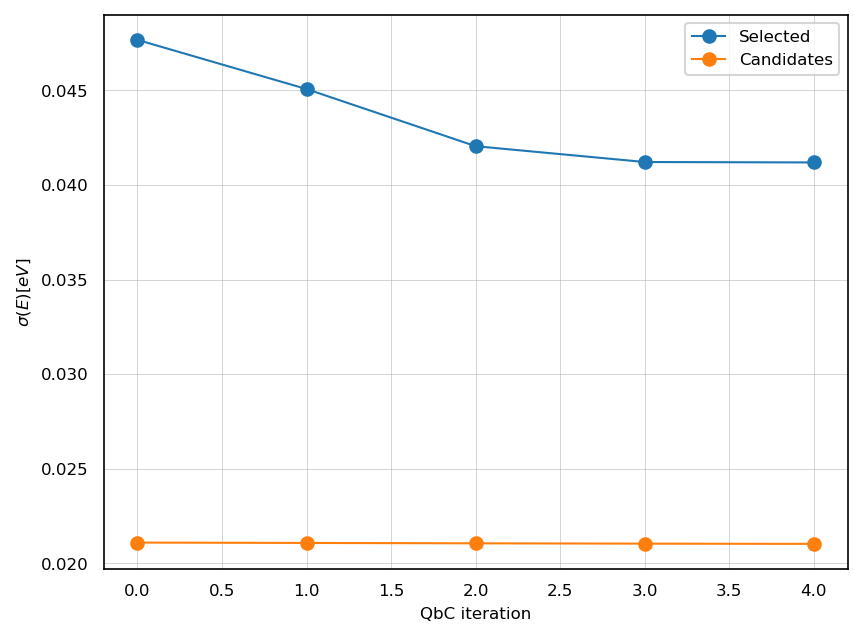

In [27]:
plt.plot(sigma[0], '-o', label='Selected')
plt.plot(sigma[1], '-o', label='Candidates')
plt.legend()
plt.xlabel('QbC iteration')
plt.ylabel(r'$\sigma(E) [eV]$')